# Simulated LSST Impactor Catalog Calculation

mjuric, September 2019.

In [1]:
## Disable threading, so that benchmarks are single-core
import os

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

NCORES = 48

In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from collections import namedtuple

In [3]:
from astropy.coordinates import Angle

# Field of view to test
lsstFoV = np.deg2rad(1.8)

## Load Impactor Dataset

In [4]:
# Add extra paths to custom versions of various packages
import sys, os, os.path

if 'OORB_DATA' not in os.environ:
    os.environ['OORB_DATA'] = '/Users/mjuric/projects/lsst_ssp/oorb-lynne/data'

extra_paths = [
    '/Users/mjuric/projects/lsst_ssp/oorb-lynne/python',
]
for _p in extra_paths:
    if not os.path.isdir(_p):
        print(f"{_p} not present. Skipping.")
        continue

    if _p not in sys.path:
        sys.path += [ _p ]
        print(f"Added {_p}")

/Users/mjuric/projects/lsst_ssp/oorb-lynne/python not present. Skipping.


In [5]:
import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord

In [6]:
import pyoorb as oo
from orbits import Orbits, PyOrbEphemerides

# FIXME: these are useful for pyoorb (and should really be in pyoorb)
oo.UTC, oo.UT1, oo.TT, oo.TAI = 1, 2, 3, 4
oo.CAR, oo.COM, oo.KEP, oo.DEL, oo.EQX = 1, 2, 3, 4, 5

# Initialize oorb. Very important. You will get '0's as earth positions otherwise.
# FIXME: the try/except construct ensures oorb_init is called only once. Calling it more than once messes up oorb.
#        This should be fixed in oorb.
try:
    oorb_initialized
except NameError:
    ephfile = os.path.join(os.getenv('OORB_DATA'), 'de430.dat')
    errcode = oo.pyoorb.oorb_init(ephfile)
    assert errcode == 0
    oorb_initialized = True

### Utilities

In [7]:
def to_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def eclToEqu(ecl):
    # ecliptic coordinate system defined with IAU1976 obliquity
    # Match OpenOrb and https://lambda.gsfc.nasa.gov/toolbox/tb_coordconv.cfm
    #
    # ecl.shape must be (3, ncoords)
    eps = np.deg2rad(23.43929111111111)
    cos_eps, sin_eps = np.cos(eps), np.sin(eps)
    
    R = np.zeros((3,3))
    R[0, :] = [1, 0, 0]
    R[1, :] = [0, cos_eps, -sin_eps]
    R[2, :] = [0, sin_eps, cos_eps]

    equ = np.matmul(R, ecl)

    return equ

### Load visits

In [8]:
# FIXME: force the user to specify the timescale for visit time
class Survey:
    def __init__(self, raVis, decVis, mjdVis, fovVis):
        # Convert visit ra,dec to unit vectors
        self.sc = SkyCoord(ra=raVis, dec=decVis, distance=1, unit=('deg', 'deg', 'au'))
        self.vec = self.sc.cartesian.xyz.value
        self.t = mjdVis
        # FIXME: this shouldn't be necessary (use np.argwhere)
        self.i = np.arange(0, len(mjdVis))
        self.fov = fovVis

    def __len__(self):
        return len(self.sc)

    def from_opsim_db(opsdbfile, fov, constraint=''):
        # Read the data you need for generating moving object positions from an opsim database
        # opsdbfile = '/epyc/projects/sssc/common/opsim_fbs1.2/baseline_1exp_pairsmix_10yrs.db'
        # constraint = ''
        #constraint = 'night <= 50'
        #constraint = 'night = 30'
        opsimdata, colmap = mLo.readOpsim(opsdbfile, constraint=constraint, footprint='circle')

        raCol, decCol, mjdCol = "fieldRA", "fieldDec", "observationStartMJD"

        return Survey(opsimdata[raCol], opsimdata[decCol], opsimdata[mjdCol], fov)

    def from_txt(fn, fov, sep='\t', nrows=None):
        # generated from opsim files using:
        # sqlite3 lsst_171year_test.db.new
        # select fieldRa as ra, fieldDec as dec, observationStartMJD + visitTime/2 as mjd, filter, visitTime, visitExposureTime, seeingFwhmEff, fiveSigmaDepth from summaryallprops;
        import pandas as pd
        df = pd.read_csv(fn, sep=sep, nrows=nrows, usecols=['ra', 'dec', 'mjd'])

        return Survey(df['ra'].values, df['dec'].values, df['mjd'].values, fov)

survey = Survey.from_txt('../../171year.csv.gz', fov=lsstFoV, sep=',')

print("number of visits:       %d" % len(survey))
print("min/max time of visit:  %.6f %.6f" % (survey.t.min(), survey.t.max()))

number of visits:       40514265
min/max time of visit:  29693.563324 92103.000000


### Load asteroids

In [9]:
# Read some test orbits
orb = Orbits()
orb.readOrbits('../../impactors.des.txt')

print("number of orbits:     %d" % len(orb))
print("min/max orbit epoch:  %.6f %.6f" % (orb.orbits['epoch'].min(), orb.orbits['epoch'].max()))

number of orbits:     10006
min/max orbit epoch:  55003.572000 91860.638000


#### Compute state vectors at regular intervals

In [14]:
def _compute_observer_position(obscode, t):
    # calculate Earth position vectors (cartesian, ecliptic) at requested times
    _ed = np.empty((len(t), 2))
    _ed[:, 0] = t
    _ed[:, 1] = oo.TT
    earthPos, err = oo.pyoorb.oorb_observer(in_obscode=obscode, in_date_ephems=_ed)
    assert err == 0

    return earthPos

def _compute_topocentric_unit_vectors(xv, obsPos):
    # shift origin to topocentric
    asts = xv[:, 1:4, :] - obsPos.T[1:4]

    # normalize the vector to 1
    norms = np.sqrt((asts*asts).sum(axis=1))
    asts /= norms[:, np.newaxis, :]

    # rotate to equatorial coordinate system
    astsEqu = np.rollaxis(eclToEqu(np.rollaxis(asts, 1, 0).reshape(3, -1)).reshape(3, asts.shape[0], asts.shape[2]), 1, 0)

    if True: # validation
        # rotate to equatorial coordinates
        testidx = 1 # 21

        _t = eclToEqu(asts[testidx, :, 1])
        assert (np.abs(_t - astsEqu[testidx, :, 1]) < 1e-15).all()

        # make sure all vectors are still properly normalized (unit vectors)
        assert (np.abs(np.square(astsEqu).sum(axis=1) - 1.) < 1e-15).all()

    return astsEqu

def _compute_on_sky_motion(asts):
    # compute the on-sky rate of motion
    import numpy.linalg as la
    r0 = asts[:, :, 0:-1]
    r0 = np.insert(r0, 0, np.nan, axis=2)
    r1 = asts

    # how much the asteroid could have moved in _previous_ night
    # note that the 0th element is NaN, as we don't have any info on how much it could have moved.
    sinDeltas = la.norm(np.cross(r0, r1, axis=1), axis=1)
    cosDeltas = (r0*r1).sum(axis=1)
    astsDelta = np.arctan2(sinDeltas, cosDeltas)
    
    return astsDelta, sinDeltas, cosDeltas

class StateGrid:
    def _propagate(self, state0, t, tmin=-np.inf, tmax=np.inf):
        # Generate states at each night on a grid defined by t. Work backwards.
        # For each asteroid, only propagate between tmin and tmax; set all other states to (0, 0, 0, 0, 0, 0)
        print('x', end='', flush=True)
        states = []
        state = state0.copy()

        # convert to oorb format
        _ed = np.empty((len(t), 2))
        _ed[:, 0], _ed[:, 1] = t, oo.TT

        for i, t in enumerate(np.flip(_ed, axis=0)):
            _active = (tmin <= t[0]) & (t[0] < tmax)
            _state = state[_active]

#            if i % 10000 == 0:
#                print((i, t[0], sum(_active)))

            if len(_state):
                _state, err = oo.pyoorb.oorb_propagation(in_orbits=_state, in_dynmodel='N', in_epoch=t)
                assert err == 0
                assert (_state[:, 8] == t[0]).all()
                state[_active] = _state

            _outstate = state.copy()
            _outstate[~_active, 1:4] = 0 # hide these asteroids are in the Sun, post impact
            _outstate[:, 8] = t[0]

            states.append(_outstate)

        # merge and reformat the array into the expected shape of (nast x 6 x nnights)
        states.reverse()
        states = np.rollaxis(np.stack(states), 0, 3)
        print('#', end='', flush=True)
        return states

    def _propagate_aux(self, st):
        return self._propagate(st[0], self.t, tmax=st[1])

    def __init__(self, orbits, tmin, tmax, obscode='I11', ncores=None, nchunks=3):
        self.orbits = orbits
        
        # orbits to work on
        pyeph = PyOrbEphemerides()
        pyeph.setOrbits(orbits)
        pyeph.convertOrbitFormat('CAR')
        # FIXME: we shouldn't be saving this... Nothing should be relying on it...
        self.pyeph = pyeph

        # min/max time to cover
        tmin, tmax = np.floor(tmin - 1), np.ceil(tmax + 1)
        self.t = t = np.arange(tmin, tmax + 1, 1.)

        # propagate
        # FIXME: tmax = ... is a hack for B612 impactor work; the interface should be generalized.
        if ncores is None:
            ncores = os.cpu_count() or 1

        if ncores == 1:
            states = self._propagate(pyeph.oorbElem, t, tmax=pyeph.oorbElem[:, 8])
        else:
            from multiprocessing import Pool

            elem_chunks = map(np.copy, to_chunks(pyeph.oorbElem, nchunks))
            tmax_chunks = map(np.copy, to_chunks(pyeph.oorbElem[:, 8], nchunks))

            with Pool(processes=ncores) as pool:
                states = np.concatenate(list(pool.map(self._propagate_aux, zip(elem_chunks, tmax_chunks))))
        print()
        # FIXME: this is not just xv, but full oorb state record -- should find a better name for it
        self.xv = states

        # Ephemerides:
        # Observer radius-vector (ICRS)
        self.obsPos = _compute_observer_position(obscode, t)
        # Topocentric equatorial unit vector
        self.vec = _compute_topocentric_unit_vectors(self.xv, self.obsPos)
        # On-sky motion
        self.delta, self.sinDelta, self.cosDelta = _compute_on_sky_motion(self.vec)

        # FIXME: this should go into IndexedSurvey.query()
        #assert tast[0] < tvisits.min()
        #assert tast[-1] > tvisits.max()

In [16]:
%%time

#states = StateGrid(orb[0::400][:5], survey.t.min(), survey.t.max(), 'I11', nchunks=3, ncores=20)
#states = StateGrid(orb[0::10], survey.t.min(), survey.t.max(), 'I11', nchunks=10, ncores=NCORES)
states = StateGrid(orb, survey.t.min(), survey.t.max(), 'I11', nchunks=10, ncores=NCORES)

print("state vector grid computed over times:  %.6f to %.6f" % (states.t.min(), states.t.max()))

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx#x##xx#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x##xx#x#x#x#x#x#x#x#x#x#x#x#x#x##xx#x#x#x#x#x#x#x#x#x#x#x#x#x#x##xx#x##xx#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x##xx#x#x#x#x#x#x#x#x#x#x#x#x#x##xx#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x##xx#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x##x#x#x#xx#x#x#x#x#x###x#xx##xx##x#x#xx#xx###xx##xx###xx##x#x#x#xx##xx###xx#xx#x####xxx##x#x#xxx####xxx#xx#x#x#x##x##x##xxx#x#xx##xxxx#x#x#x###xx#xx#x##x#xx#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x##x#x#x#x#x#xx#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x##x#xx#x#x#x#x#x#x#x#x#x#x#x#x#x#x##xx#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x###x#xxx#x#x#x#x#x##x#xx#x#x###x#x#x#x#x#xx#x#xx#x#x##xx#x##xx#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x#x

In [147]:
assert np.all(states.xv == states0.xv)

In [14]:
import pickle
with open("states.pkl", "wb") as fp:
    pickle.dump(states, fp, protocol=4)

## Visualize the dataset

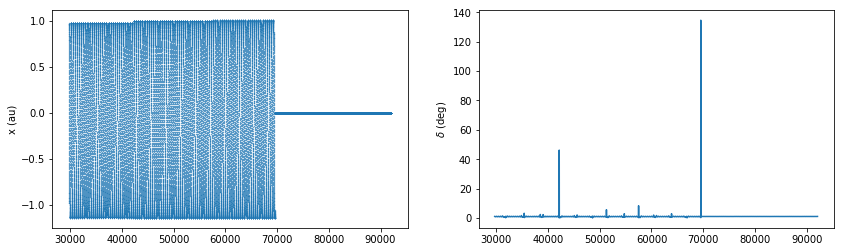

In [17]:
import matplotlib.pyplot as plt
def _plot_ast(states, idx):
    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(states.xv[idx, 8], states.xv[idx, 1], s=0.1)
    ax.set_ylabel("x (au)")
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(states.t, np.rad2deg(states.delta[idx]))
    ax.set_ylabel(r"$\delta$ (deg)")

_plot_ast(states, 0)

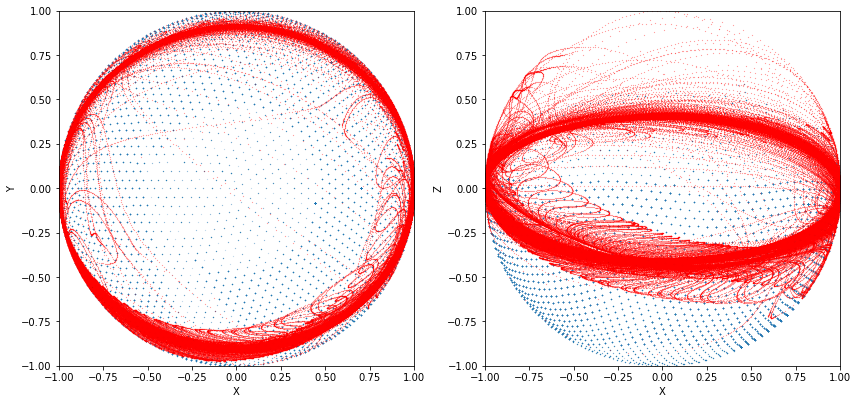

In [18]:
def _visualize(survey, states):
    visits = survey.vec
    asts = states.vec

    # subsample visits, to make the plot look reasonable
    rnd.seed(42)
    aidx = rnd.choice(asts.shape[0], 5)
    idx = rnd.choice(survey.vec.shape[1], 50_000)

    fig = plt.figure(figsize=(14,7))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_aspect('equal')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.scatter(visits[0, idx], visits[1, idx], s=0.01)
    ax.scatter(asts[aidx, 0], asts[aidx, 1], s=0.02, c='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    ax = fig.add_subplot(1, 2, 2)
    ax.set_aspect('equal')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.scatter(visits[0, idx], visits[2, idx], s=0.01)
    ax.scatter(asts[aidx, 0], asts[aidx, 2], s=0.02, c='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Z');

_visualize(survey, states)

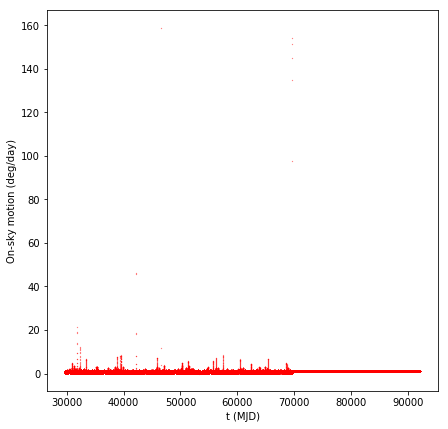

In [19]:
def _plot_sky_motion(states, idx=None):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1, 1, 1)

    deltaDeg = np.rad2deg(states.delta[idx])
    ax.scatter(np.broadcast_to(states.t, deltaDeg.shape), deltaDeg, s=0.04, c='red')

    ax.set_xlabel('t (MJD)')
    ax.set_ylabel('On-sky motion (deg/day)');

# plot the on-sky motion of a subset of objects
_plot_sky_motion(states, slice(0, 5))

## Test 0: Compute/Load Ground Truth

The ground truth are the ephemerides of all asteroids propagated at the exact epochs of all visits (~3M visits).

In [171]:
%%time
# Compute positions at exact visit times, for every visit. This is _very_
# computationally expensive, so we save the result for future re-use.

cachefn = 'impactors-ephems-5.ndarray'
computeCache = False

nast = len(states.pyeph.oorbElem)
ntimes = len(survey.t)

if computeCache:
    _pyeph = PyOrbEphemerides()
    _pyeph.setOrbits(orb[0:1])
    _pyeph.convertOrbitFormat('CAR')

    # output array (nast x ntimes x 2)
    fp = np.memmap(cachefn, dtype='float64', mode='w+', shape=(nast, ntimes, 2))

    # generate impactor ephemerides, object by object, up to state vector epoch
    for k in range(len(pyeph.oorbElem)):
        _pyeph.oorbElem[0:1] = states.pyeph.oorbElem[k]
        _active = tvisits < _pyeph.oorbElem[0, 8]
        _active, = np.nonzero(_active)
#        _active = _active[-200000:]
        _tvisits = tvisits[_active]
        print(k, len(_tvisits), ' t=', _tvisits[-1])
        ephems = _pyeph.generateEphemerides(_tvisits, timeScale='TT')
        fp[k, _active, 0] = ephems[0, :]['ra']
        fp[k, _active, 1] = ephems[0, :]['dec']
        print('  geodist=', ephems['geo_dist'][0, -1])

    del fp

if True:
    # read from mmapped array
    fp = np.memmap(cachefn, dtype='float64', mode='r', shape=(nast, ntimes, 2))
    raEph = fp[:, :, 0]
    decEph = fp[:, :, 1]

CPU times: user 907 µs, sys: 1.58 ms, total: 2.48 ms
Wall time: 15.9 ms


In [174]:
np.searchsorted(states.t, survey.t[25878665])

39842

In [193]:
# Debug a particular asteroid, visit, time combination
#iast, ivis, it = 27, 30, 1
#iast, ivis, it = 0, 13565, 18
##iast, ivis, it = 0, 1200109, 1808
##iast, ivis, it = 0, 5931008, 9082
##iast, ivis, it = 0, 38043650, 58619
iast, ivis, it = 0, 25878665, 39842

# Compare the exactly-calculated separation to the approximate one
astPos = SkyCoord(ra=raEph[iast][ivis], dec=decEph[iast][ivis], unit='deg')
visPos = SkyCoord(ra=raVis[ivis], dec=decVis[ivis], unit='deg')
print('Exact:')
print('radec vis  =', raVis[ivis], decVis[ivis])
print('radec ast  =', raEph[iast][ivis], decEph[iast][ivis])
print('visPos     =', visPos.cartesian.xyz.value, 't=', survey.t[ivis])
print('astPos     =', astPos.cartesian.xyz.value, 't=', survey.t[ivis])
print('exact sep  =', astPos.separation(visPos).degree, 'deg')
print()

print('Approximate:')
print('vis        = ', survey.vec[:, ivis], 't=', survey.t[ivis])
print('asts       = ', states.vec[iast][:, it], 't=', states.t[it])
print('approx sep = ', np.rad2deg(np.arccos((states.vec[iast][:, it] * survey.vec[:, ivis]).sum())), 'deg')
print('search rad = ', np.rad2deg(np.arccos(cosRfov*states.cosDelta[iast, it] - sinRfov*states.sinDelta[iast, it])), 'deg' )

Exact:
radec vis  = 104.658778 -22.267310000000002
radec ast  = 192.49774559906936 -50.549143517869
visPos     = [-0.23419014  0.89530351 -0.37892822] t= 69533.4677964762
astPos     = [-0.62035966 -0.13750482 -0.77216987] t= 69533.4677964762
exact sep  = 71.65303864933 deg

Approximate:
vis        =  [-0.23419014  0.89530351 -0.37892822] t= 69533.4677964762
asts       =  [0.97442384 0.20617524 0.08938648] t= 69534.0
approx sep =  94.44385133495689 deg
search rad =  136.47270958187767 deg


In [204]:
# Compute the `truth` -- a list of visits where each asteroid was imaged.
def compute_truth(survey, raEph, decEph):
    truth = []
    for _ra, _dec in zip(raEph, decEph):
        _valid = (_ra != 0) & (_dec != 0)
        _ra, _dec = _ra[_valid], _dec[_valid]
        astSc = SkyCoord(ra=_ra, dec=_dec, unit='deg')
        sep = survey.sc[_valid].separation(astSc)
        truth += [ survey.i[_valid][sep.radian < survey.fov] ]
    return truth

truth = compute_truth(survey, raEph, decEph)
list(map(len, truth))[:10]

[3179, 3261, 3230, 8704, 4453]

In [38]:
# [13706, 14148, 16762]
# [3179, 3261, 3230, 8704, 4453]

## Test 1: Direct dot product

Algorithm:
* For each visit, find the corresponding asteroid observation (the closest one _after_ the visit time)
* Compute `cosR`, the maximum radius in which the asteroid could have moved between the observations. This is the asteroid motion plus FoV radius. We assume the path between points has been approximately linear.
* Compute the dot product of all fields and the corresponding asteroids.
* Keep only those with the `product > cosR`

In [224]:
%%time
class DotProductIndex:
    def __init__(self, survey, states):
        self.survey = survey
        self.i = np.searchsorted(states.t, survey.t)

    def query(self, states):
        i, survey = self.i, self.survey

        z = []
        cosRfov, sinRfov = np.cos(survey.fov), np.sin(survey.fov)
        for ast, cosDelta, sinDelta in zip(states.vec, states.cosDelta, states.sinDelta):
            # get asteroid position-vector at nearest time not less then time of each visit
            # shape: (3, nvisits)
            astvis = ast[:, i]

            # get the on-sky distance the asteroid could have covered
            # around the time this visit was taken
            cosR = cosRfov*cosDelta[i] - sinRfov*sinDelta[i]

            # keep only plausable visits
            z += [ survey.i[ (survey.vec*astvis).sum(axis=0) >= cosR ] ]
        return z

dotIndex = DotProductIndex(survey, states)
found_dot = dotIndex.query(states)

CPU times: user 13.7 s, sys: 6.88 s, total: 20.6 s
Wall time: 21.1 s


In [225]:
list(map(len, found_dot))

[7457, 5321, 4523, 11550, 7399]

In [226]:
# [7457, 5321, 4523, 11550, 7399]

In [227]:
def _is_subset_of_truth(found, truth):
    # validate truth is a subset of these
    for ii, (zz, tt) in enumerate(zip(found, truth)):
        assert set(tt) <= set(zz), (len(set(tt)), len(set(zz)), set(zz) - set(tt))
    zzsum = sum(map(len, found))
    ttsum = sum(map(len, truth))
    print("Overlapping visit candidates:", zzsum)
    print("Exact overlaps:", ttsum)
    print("Efficiency: %.2f" % (ttsum / zzsum))

_is_subset_of_truth(found_dot, truth)

Overlapping visit candidates: 36250
Exact overlaps: 22827
Efficiency: 0.63


In [ ]:
%%timeit
dotIndex.query(states)

## Test 2: Search Trees

Algorithm:
* Assumptions:
  * Asteroids ephemeris are all computed at the same time (note: doesn't have to be at equal intervals).
* Prepare:
  * Divide visits into groups, one per nights
  * For each group, create a 3D search tree on unit vectors representing the visits (BallTrees seem to work best)
* Search:
  * Compute `searchR`, the 3D search radius corresponding to angle each asteroid could have moved
  * For each night:
    * Run an objects-within-radius search (for all asteroids at once)
  * Return a lists of potential visit IDs, one list per asteroid

In [20]:
%%time

from sklearn.neighbors import KDTree, BallTree
import numpy.linalg as la

class TreeIndex(object):
    tree = None

    def __init__(self, survey, dt = 1., toffs = 0.0):
        t0 = np.floor(survey.t.min()) - toffs
        t1 = np.ceil(survey.t.max()) + dt

        nightT = np.arange(t0, t1, dt)
        nightRanges = np.searchsorted(survey.t, nightT)
        
        # build an array of KDTrees for each visit, one per interval
        tree = []
        for idx in range(0, len(nightT)-1):
            start, end = nightRanges[idx:idx+2]
            xnight = survey.vec.T[start:end]
            xt = survey.t[start:end]
            if len(xt):
                assert((nightT[idx] <= xt.min()) & (xt.max() < nightT[idx+1]))
                tr = BallTree(xnight, leaf_size=25)
            else:
                tr = None
            tree += [ ( tr, start, nightT[idx], nightT[idx+1] ) ]
        tree += [ (None, nightRanges[-1], nightT[-1], np.inf) ]
        
        self.nightT = nightT
        self.dt = dt
        self.tree = tree
        self.survey = survey

    def query(self, states, ncores=None):
        asts, tast, astsDelta = states.vec, states.t, states.delta
        tree, nightT, dt, Rfov = self.tree, self.nightT, self.dt, self.survey.fov

        # the algorithm is in its own function so we don't have to be re-creating
        # the object and rebuilding the class while interactivelly changing it while
        # developing/debugging.
        return _tree_query_aux(asts, tast, astsDelta, tree, nightT, dt, Rfov, ncores)

vtree = TreeIndex(survey)

CPU times: user 19.7 s, sys: 5.85 s, total: 25.6 s
Wall time: 47.3 s


In [21]:
def _tree_query_aux(asts, tast, astsDelta, tree, nightT, dt, Rfov, ncores):
    # check the inputs are OK
    # 1. there has to be at least one ephem per night
    assert np.all(np.diff(tast) <= dt)
    # 2. ephems must cover all nights
    assert tast[0] < tree[0][2]
    assert tast[-1] < tree[-1][3]

    searchR = 2.*np.sin(0.5*(Rfov + astsDelta))

    # divide up the asteroid ephemeris into "nights"
    # allows for more than one ephem per night
    astTimeRanges = np.searchsorted(tast, nightT, side='right')

    global _global_state
    _global_state = (astTimeRanges, asts, tast, tree, nightT, dt, searchR)

    def _run(mapfunc):
        found = [[] for _ in asts ]

        import time
        t0 = time.time()
        for at, matches in enumerate(mapfunc(_tree_query_aux_mapper, range(len(nightT)))):
            if at > 0 and at % 365*5 == 0:
                frac = at/len(nightT)

                t1 = time.time()
                dt = (t1 - t0) / 60. # time in minutes
                dtr = dt/frac - dt # time remaining

                print(f"Processed {at/365} survey years ({frac*100:.1f}%) in {dt:.1f} minutes ({dtr:.1f} remaining)")
            for i, th in matches.items():
                found[i].append(th)

        found = [ np.concatenate(f) for f in found ]
        return found

    if ncores is None:
        ncores = os.cpu_count() or 1

    if ncores == 1:
        found = _run(map)
    else:
        from multiprocessing import Pool
        with Pool(processes=ncores) as pool:
            found = _run(pool.imap_unordered)

    return found

_global_state = None
def _tree_query_aux_mapper(night):
    astTimeRanges, asts, tast, tree, nightT, dt, searchR = _global_state
    t = nightT[night]

    found = {}

    tr, offs, t0, t1 = tree[night]
    dtvis = t1 - t0
    assert t0 <= t < t1
    if tr is None:
        return {}

    start, end = astTimeRanges[night:night+2]
    # all asteroid ephemeris must fall into this "night"
    assert t0 < tast[start] and tast[end-1] <= t1

    for idx in range(start, end):
        ta, tb = tast[idx-1], tast[idx]
        dtast = tb - ta
        this = offs + tr.query_radius(asts[:, :, idx], r=searchR[:, idx])
        for i, th in enumerate(this):
            if not len(th):
                continue
            # keep only those in a valid time range for this asteroid
            if dtast < dtvis: # w/o this if, the subsequent line almost doubles the runtime (!)
                th = th[(ta < survey.t[th]) & (survey.t[th] <= tb)]
            found[i] = th.copy()

    return found

In [22]:
%%time

found = vtree.query(states, ncores=NCORES)

validate = False
if validate:
    _is_subset_of_truth(found, truth)
else:
    print("WARNING: Validation turned off.")

Processed 1.0 survey years (0.6%) in 0.0 minutes (6.9 remaining)
Processed 2.0 survey years (1.2%) in 0.1 minutes (6.1 remaining)
Processed 3.0 survey years (1.8%) in 0.1 minutes (6.1 remaining)
Processed 4.0 survey years (2.3%) in 0.1 minutes (6.0 remaining)
Processed 5.0 survey years (2.9%) in 0.2 minutes (5.9 remaining)
Processed 6.0 survey years (3.5%) in 0.2 minutes (5.9 remaining)
Processed 7.0 survey years (4.1%) in 0.2 minutes (5.7 remaining)
Processed 8.0 survey years (4.7%) in 0.3 minutes (5.7 remaining)
Processed 9.0 survey years (5.3%) in 0.3 minutes (5.7 remaining)
Processed 10.0 survey years (5.8%) in 0.4 minutes (5.7 remaining)
Processed 11.0 survey years (6.4%) in 0.4 minutes (5.7 remaining)
Processed 12.0 survey years (7.0%) in 0.4 minutes (5.6 remaining)
Processed 13.0 survey years (7.6%) in 0.5 minutes (5.5 remaining)
Processed 14.0 survey years (8.2%) in 0.5 minutes (5.5 remaining)
Processed 15.0 survey years (8.8%) in 0.5 minutes (5.4 remaining)
Processed 16.0 surv

Processed 124.0 survey years (72.5%) in 4.0 minutes (1.5 remaining)
Processed 125.0 survey years (73.1%) in 4.1 minutes (1.5 remaining)
Processed 126.0 survey years (73.7%) in 4.1 minutes (1.5 remaining)
Processed 127.0 survey years (74.3%) in 4.1 minutes (1.4 remaining)
Processed 128.0 survey years (74.9%) in 4.2 minutes (1.4 remaining)
Processed 129.0 survey years (75.4%) in 4.2 minutes (1.4 remaining)
Processed 130.0 survey years (76.0%) in 4.2 minutes (1.3 remaining)
Processed 131.0 survey years (76.6%) in 4.3 minutes (1.3 remaining)
Processed 132.0 survey years (77.2%) in 4.3 minutes (1.3 remaining)
Processed 133.0 survey years (77.8%) in 4.3 minutes (1.2 remaining)
Processed 134.0 survey years (78.4%) in 4.4 minutes (1.2 remaining)
Processed 135.0 survey years (79.0%) in 4.4 minutes (1.2 remaining)
Processed 136.0 survey years (79.5%) in 4.4 minutes (1.1 remaining)
Processed 137.0 survey years (80.1%) in 4.5 minutes (1.1 remaining)
Processed 138.0 survey years (80.7%) in 4.5 minu

In [23]:
list(map(len, found[:10]))

[7457, 7589, 6133, 4382, 7489, 8510, 7841, 7409, 6883, 6840]

In [28]:
# [7457, 5321, 4523, 11550, 7399]
# [7457, 4955, 4144, 7854, 4825, 10243, 11028, 10042, 7923, 10161]

In [48]:
%%timeit
vtree.query(states)

5.75 s ± 56.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [166]:
# verify thata single-threaded result returns the same as a multi-threaded result.
# assumes you've run the query in a single thread and stored the result as found0
assert len(found0) == len(found)
for f0, f1 in zip(found0, found):
    assert set(f0) == set(f1)

## Exact computation

Given a list of candidate overlapping visits, compute the exact asteroid ephemerides at those times and keep only those that actually overlap the visits.

In [24]:
def compute_ephemeris_slow(oorbElem):
    # ground truth -- compute the same thing with the "classical" ephem calculator
    # and verify the results are bitwise identical
    ephems = np.empty((len(oorbElem), 11))
    for idx, _ in enumerate(oorbElem):
        ephems[idx], err = oo.pyoorb.oorb_ephemeris_basic(oorbElem[idx:idx+1, :12], 
                                                in_obscode='I11', in_dynmodel='N',
                                               in_date_ephems=oorbElem[idx:idx+1, 12:14])
        assert err == 0
    return ephems

In [25]:
%%time

_global_survey = None
_global_states = None
def _compute_exact_matches_single(item):
    survey, states = _global_survey, _global_states
    i, vv = item

    # vv: indicies of candidate intersecting visits
    ##tv, ravv, decvv = survey.t[vv], survey.sc.ra[vv], survey.sc.dec[vv]  # time, ra, dec of candidate visits
    tv = survey.t[vv]

    # Find indices of state vectors closest in time to the candidate visits
    tast = states.xv[i, 8]
    idx = np.searchsorted(tast, tv) - 1
    assert np.all(idx >= 0)

    # construct input arrays for propagation and propagate them to exact visit times
    oorbElem = np.zeros([len(vv), 14], dtype=np.double, order='F')
    oorbElem[:, :12] = states.xv[i, :12, idx]
    oorbElem[:, 12] = tv
    oorbElem[:, 13] = oo.TT
    eph = compute_ephemeris_slow(oorbElem)

    # find which asteroids actually overlap the visits
    visSc = survey.sc[vv] # SkyCoord(ra=ravv, dec=decvv, unit='deg')
    astSc = SkyCoord(ra=eph[:, 1], dec=eph[:, 2], unit='deg')
    sep = visSc.separation(astSc)
    didhit = sep.radian < survey.fov

    return vv[didhit], eph[didhit]

def compute_exact_matches(found, survey, states, ncores=None):
    # construct a partial function that will only take a single arg, so we
    # can call map on it. This is not because I want everyone to learn functional programming,
    # (which you should :-) ), but because it makes it trivial to replace map with Pool.map for
    # and make the result multi-threaded
    ##from functools import partial
    ##_compute_matches = partial(_compute_exact_matches_single, survey=survey, states=states)

    # a trick to prevent multiprocessing.pool from trying to pickle survey and states (which can be huge)
    global _global_survey, _global_states
    _global_survey, _global_states = survey, states

    # See https://stackoverflow.com/a/7558990 if you're not familiar with the
    # list_1, list_2 = zip(*list_of_pairs) idiom
    _do_matches = lambda mapfunc, found: zip(*mapfunc(_compute_exact_matches_single, enumerate(found)))

    if ncores is None:
        ncores = os.cpu_count() or 1

    if ncores == 1:
        hit, ephhit = _do_matches(map, found)
    else:
        from multiprocessing import Pool
        with Pool(processes=ncores) as pool:
            hit, ephhit = _do_matches(pool.map, found)

    return hit, ephhit

hits, ephems = compute_exact_matches(found, survey, states, ncores=NCORES)
print(list(map(len, hits[:10])))

[3182, 4605, 2977, 1862, 2293, 4335, 4126, 3655, 3483, 3604]
CPU times: user 7.07 s, sys: 2min 21s, total: 2min 28s
Wall time: 25min 38s


In [39]:
# [3182, 3509, 1409, 4657, 2018, 5447, 8569, 8010, 5508, 7653]

In [280]:
from astropy.time import Time
from astropy.coordinates import Angle

def plot_deltas(t, sep, geo_dist):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    fig.suptitle(f"Asteroid #{i}")

    ax1.scatter(t.mjd, sep.arcsec, s=0.1)
    ax1.set_ylim(0, 1.1*sep.arcsec.max())
    ax1.set_ylabel("Δpos [arcsec]")

    ax2.scatter(s1.obstime.mjd, geo_dist, s=0.1)
    ax2.set_xlabel("time [mjd]")
    ax2.set_ylabel("geocentric distance [au]")

def _is_identical_to_truth(survey, found, truth, hits, ephems):
    for i, (hit, ephem, vv, truthHit) in enumerate(zip(hits, ephems, found, truth)):
        # compare to directly propagated ephems
        s1 = SkyCoord(ra=ephem[:, 1],  dec=ephem[:, 2],   obstime=Time(ephem[:, 0],  format='mjd', scale='tt'), unit='deg')
        s2 = SkyCoord(ra=raEph[i, hit], dec=decEph[i, hit], obstime=Time(survey.t[hit],  format='mjd', scale='tt'),  unit='deg')
        sep = s1.separation(s2)
        dt = s2.obstime - s1.obstime

        # --- FIXME: remove all hits where truth table hasn't been computed
        hit = hit[raEph[i, hit] != 0.]
        keep = s2.ra != 0.
        sep, dt = sep[keep], dt[keep]
        # --- FIXME

        if len(vv):
            imax = np.argmax(sep.arcsec)
            msg  = f"Asteroid #{i} found in {len(hit)} out of {len(vv)} candidate visits ({round(100*len(hit)/len(vv), 2)}%)"
            msg += "\n            max(Δpos) = %.2e arcsec at vis=%d, t=%s, geo_dist=%.2e au" % (sep.arcsec.max(), vv[imax], s1.obstime[imax], ephem[imax, 8])
            print(msg)
        else:
            print(f"Asteroid #{i} not imaged.")

        # uncomment to get a plot of differences
        # plot_deltas(s1.obstime, sep, ephem[:, 8])

        #plt.scatter(ephem[:, 8], sep.arcsec, s=0.1)
        #plt.xscale('log')
        #plt.suptitle(f'Asteroid #{i}')

        verify = True
        if verify:
            # verification: have we found all visits as given by the truth table?
            assert set(truthHit) == set(hit), set(truthHit) - set(hit)

            # verification: make sure there are no differences relative to directly propagated ephems
            assert np.all(dt == 0), f"Max differences vs truth: Δt = {dt.max()}"
            assert np.all(sep < Angle(2., unit='arcsec')), f"Max differences vs truth: Δpos = {sep.arcsecond.max()} arcsec"

_is_identical_to_truth(survey, found, truth, hits, ephems)

Asteroid #0 found in 3179 out of 7457 candidate visits (42.63%)
            max(Δpos) = 1.99e+00 arcsec at vis=1571962, t=35413.824227211604, geo_dist=9.13e-02 au
Asteroid #1 found in 3261 out of 5321 candidate visits (61.29%)
            max(Δpos) = 1.01e-02 arcsec at vis=9938091, t=54583.0901575872, geo_dist=3.31e-02 au
Asteroid #2 found in 3230 out of 4523 candidate visits (71.41%)
            max(Δpos) = 1.00e-03 arcsec at vis=6554342, t=44711.3423869338, geo_dist=9.46e-02 au
Asteroid #3 found in 8704 out of 11550 candidate visits (75.36%)
            max(Δpos) = 7.31e-03 arcsec at vis=10769116, t=51284.4000649947, geo_dist=2.36e-01 au
Asteroid #4 found in 4453 out of 7399 candidate visits (60.18%)
            max(Δpos) = 2.85e-01 arcsec at vis=1036153, t=32815.6176647116, geo_dist=3.95e-02 au


In [52]:
%%timeit
hits, ephems = compute_exact_matches(found, survey, states)

6.91 s ± 77.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Store output to files

In [26]:
import pandas as pd

def to_df(i, states, hit, ephem):
    objId = states.orbits.orbits["objId"]

    df = pd.DataFrame(ephem)
    df.columns = 'mjd ra dec vra vdec phase solarElon helioD geoD Vmag true_anomaly'.split()
    df['H'] = states.xv[i, :, 0][10]
    df['G'] = states.xv[i, :, 0][11]
    df.insert(0, 'visitIdx', hit)
    df.insert(0, 'objId', objId.loc[i])
    return df

def to_csv(fn, states, hits, ephems):
    with open(fn, 'w') as fp:
        objId = states.orbits.orbits["objId"]
        for i, (hit, ephem) in enumerate(zip(hits, ephems)):
            print(f"Asteroid {i}, objId={objId.loc[i]}: {len(hit)} observations")
            df = to_df(i, states, hit, ephem)
            df.to_csv(fp, index=False, sep=' ', header=(i==0))

# FIXME: make the output prettier -- sane number of decimal places, aligned columns
to_csv('catalog.txt', states, hits, ephems)

Asteroid 0, objId=3901: 3182 observations
Asteroid 1, objId=3902: 4605 observations
Asteroid 2, objId=3903: 2977 observations
Asteroid 3, objId=3904: 1862 observations
Asteroid 4, objId=3905: 2293 observations
Asteroid 5, objId=3906: 4335 observations
Asteroid 6, objId=3907: 4126 observations
Asteroid 7, objId=3908: 3655 observations
Asteroid 8, objId=3909: 3483 observations
Asteroid 9, objId=3910: 3604 observations
Asteroid 10, objId=3911: 3509 observations
Asteroid 11, objId=3912: 3118 observations
Asteroid 12, objId=3913: 3201 observations
Asteroid 13, objId=3914: 1696 observations
Asteroid 14, objId=3915: 6372 observations
Asteroid 15, objId=3916: 7509 observations
Asteroid 16, objId=3917: 1738 observations
Asteroid 17, objId=3918: 5564 observations
Asteroid 18, objId=3919: 3859 observations
Asteroid 19, objId=3920: 293 observations
Asteroid 20, objId=3921: 1409 observations
Asteroid 21, objId=3922: 3472 observations
Asteroid 22, objId=3923: 4025 observations
Asteroid 23, objId=392

Asteroid 190, objId=4091: 3119 observations
Asteroid 191, objId=4092: 813 observations
Asteroid 192, objId=4093: 2840 observations
Asteroid 193, objId=4094: 5237 observations
Asteroid 194, objId=4095: 3482 observations
Asteroid 195, objId=4096: 2236 observations
Asteroid 196, objId=4097: 1485 observations
Asteroid 197, objId=4098: 3489 observations
Asteroid 198, objId=4099: 4566 observations
Asteroid 199, objId=4100: 1560 observations
Asteroid 200, objId=4101: 3327 observations
Asteroid 201, objId=4102: 3564 observations
Asteroid 202, objId=4103: 3985 observations
Asteroid 203, objId=4104: 3836 observations
Asteroid 204, objId=4105: 2435 observations
Asteroid 205, objId=4106: 5688 observations
Asteroid 206, objId=4107: 4297 observations
Asteroid 207, objId=4108: 1550 observations
Asteroid 208, objId=4109: 5762 observations
Asteroid 209, objId=4110: 735 observations
Asteroid 210, objId=4111: 4663 observations
Asteroid 211, objId=4112: 3650 observations
Asteroid 212, objId=4113: 578 obse

Asteroid 377, objId=4278: 9430 observations
Asteroid 378, objId=4279: 3350 observations
Asteroid 379, objId=4280: 4381 observations
Asteroid 380, objId=4281: 2957 observations
Asteroid 381, objId=4282: 10037 observations
Asteroid 382, objId=4283: 3449 observations
Asteroid 383, objId=4284: 2505 observations
Asteroid 384, objId=4285: 7023 observations
Asteroid 385, objId=4286: 3151 observations
Asteroid 386, objId=4287: 4310 observations
Asteroid 387, objId=4288: 3495 observations
Asteroid 388, objId=4289: 3673 observations
Asteroid 389, objId=4290: 3215 observations
Asteroid 390, objId=4291: 8610 observations
Asteroid 391, objId=4292: 1803 observations
Asteroid 392, objId=4293: 2384 observations
Asteroid 393, objId=4294: 3039 observations
Asteroid 394, objId=4295: 9603 observations
Asteroid 395, objId=4296: 4213 observations
Asteroid 396, objId=4297: 3488 observations
Asteroid 397, objId=4298: 7474 observations
Asteroid 398, objId=4299: 1263 observations
Asteroid 399, objId=4300: 3009 

Asteroid 564, objId=4465: 64 observations
Asteroid 565, objId=4466: 7169 observations
Asteroid 566, objId=4467: 6289 observations
Asteroid 567, objId=4468: 7574 observations
Asteroid 568, objId=4469: 4675 observations
Asteroid 569, objId=4470: 1851 observations
Asteroid 570, objId=4471: 5063 observations
Asteroid 571, objId=4472: 3151 observations
Asteroid 572, objId=4473: 2128 observations
Asteroid 573, objId=4474: 3480 observations
Asteroid 574, objId=4475: 3499 observations
Asteroid 575, objId=4476: 6410 observations
Asteroid 576, objId=4477: 5304 observations
Asteroid 577, objId=4478: 3369 observations
Asteroid 578, objId=4479: 3172 observations
Asteroid 579, objId=4480: 3412 observations
Asteroid 580, objId=4481: 6288 observations
Asteroid 581, objId=4482: 5421 observations
Asteroid 582, objId=4483: 4069 observations
Asteroid 583, objId=4484: 8696 observations
Asteroid 584, objId=4485: 3980 observations
Asteroid 585, objId=4486: 786 observations
Asteroid 586, objId=4487: 763 obser

Asteroid 753, objId=4654: 2513 observations
Asteroid 754, objId=4655: 1962 observations
Asteroid 755, objId=4656: 5744 observations
Asteroid 756, objId=4657: 5111 observations
Asteroid 757, objId=4658: 8125 observations
Asteroid 758, objId=4659: 6115 observations
Asteroid 759, objId=4660: 148 observations
Asteroid 760, objId=4661: 4122 observations
Asteroid 761, objId=4662: 8108 observations
Asteroid 762, objId=4663: 3833 observations
Asteroid 763, objId=4664: 6373 observations
Asteroid 764, objId=4665: 4410 observations
Asteroid 765, objId=4666: 2726 observations
Asteroid 766, objId=4667: 2822 observations
Asteroid 767, objId=4668: 577 observations
Asteroid 768, objId=4669: 2633 observations
Asteroid 769, objId=4670: 5106 observations
Asteroid 770, objId=4671: 5101 observations
Asteroid 771, objId=4672: 2144 observations
Asteroid 772, objId=4673: 2993 observations
Asteroid 773, objId=4674: 7593 observations
Asteroid 774, objId=4675: 4764 observations
Asteroid 775, objId=4676: 830 obse

Asteroid 941, objId=4842: 1514 observations
Asteroid 942, objId=4843: 7430 observations
Asteroid 943, objId=4844: 6504 observations
Asteroid 944, objId=4845: 1489 observations
Asteroid 945, objId=4846: 6804 observations
Asteroid 946, objId=4847: 5368 observations
Asteroid 947, objId=4848: 8602 observations
Asteroid 948, objId=4849: 7491 observations
Asteroid 949, objId=4850: 8292 observations
Asteroid 950, objId=4851: 8190 observations
Asteroid 951, objId=4852: 10281 observations
Asteroid 952, objId=4853: 2629 observations
Asteroid 953, objId=4854: 5359 observations
Asteroid 954, objId=4855: 2566 observations
Asteroid 955, objId=4856: 1158 observations
Asteroid 956, objId=4857: 4270 observations
Asteroid 957, objId=4858: 4915 observations
Asteroid 958, objId=4859: 1972 observations
Asteroid 959, objId=4860: 3009 observations
Asteroid 960, objId=4861: 2016 observations
Asteroid 961, objId=4862: 3318 observations
Asteroid 962, objId=4863: 2979 observations
Asteroid 963, objId=4864: 4136 

Asteroid 1125, objId=5026: 8552 observations
Asteroid 1126, objId=5027: 5186 observations
Asteroid 1127, objId=5028: 2629 observations
Asteroid 1128, objId=5029: 7686 observations
Asteroid 1129, objId=5030: 839 observations
Asteroid 1130, objId=5031: 6305 observations
Asteroid 1131, objId=5032: 5190 observations
Asteroid 1132, objId=5033: 5209 observations
Asteroid 1133, objId=5034: 7882 observations
Asteroid 1134, objId=5035: 5066 observations
Asteroid 1135, objId=5036: 7835 observations
Asteroid 1136, objId=5037: 812 observations
Asteroid 1137, objId=5038: 260 observations
Asteroid 1138, objId=5039: 7427 observations
Asteroid 1139, objId=5040: 3329 observations
Asteroid 1140, objId=5041: 3026 observations
Asteroid 1141, objId=5042: 7083 observations
Asteroid 1142, objId=5043: 6016 observations
Asteroid 1143, objId=5044: 5454 observations
Asteroid 1144, objId=5045: 9197 observations
Asteroid 1145, objId=5046: 4838 observations
Asteroid 1146, objId=5047: 4667 observations
Asteroid 1147

Asteroid 1309, objId=5210: 5819 observations
Asteroid 1310, objId=5211: 10104 observations
Asteroid 1311, objId=5212: 466 observations
Asteroid 1312, objId=5213: 2642 observations
Asteroid 1313, objId=5214: 8549 observations
Asteroid 1314, objId=5215: 6519 observations
Asteroid 1315, objId=5216: 1996 observations
Asteroid 1316, objId=5217: 8306 observations
Asteroid 1317, objId=5218: 8952 observations
Asteroid 1318, objId=5219: 1889 observations
Asteroid 1319, objId=5220: 3264 observations
Asteroid 1320, objId=5221: 8062 observations
Asteroid 1321, objId=5222: 9703 observations
Asteroid 1322, objId=5223: 7726 observations
Asteroid 1323, objId=5224: 2 observations
Asteroid 1324, objId=5225: 4753 observations
Asteroid 1325, objId=5226: 5056 observations
Asteroid 1326, objId=5227: 8100 observations
Asteroid 1327, objId=5228: 656 observations
Asteroid 1328, objId=5229: 4626 observations
Asteroid 1329, objId=5230: 30 observations
Asteroid 1330, objId=5231: 92 observations
Asteroid 1331, obj

Asteroid 1492, objId=5393: 387 observations
Asteroid 1493, objId=5394: 6175 observations
Asteroid 1494, objId=5395: 9005 observations
Asteroid 1495, objId=5396: 4314 observations
Asteroid 1496, objId=5397: 7056 observations
Asteroid 1497, objId=5398: 10122 observations
Asteroid 1498, objId=5399: 1829 observations
Asteroid 1499, objId=5400: 4822 observations
Asteroid 1500, objId=5401: 8276 observations
Asteroid 1501, objId=5402: 8466 observations
Asteroid 1502, objId=5403: 7571 observations
Asteroid 1503, objId=5404: 4512 observations
Asteroid 1504, objId=5405: 6343 observations
Asteroid 1505, objId=5406: 7707 observations
Asteroid 1506, objId=5407: 9336 observations
Asteroid 1507, objId=5408: 4370 observations
Asteroid 1508, objId=5409: 8722 observations
Asteroid 1509, objId=5410: 28 observations
Asteroid 1510, objId=5411: 4488 observations
Asteroid 1511, objId=5412: 8665 observations
Asteroid 1512, objId=5413: 2944 observations
Asteroid 1513, objId=5414: 7095 observations
Asteroid 151

Asteroid 1677, objId=5578: 4178 observations
Asteroid 1678, objId=5579: 3358 observations
Asteroid 1679, objId=5580: 3719 observations
Asteroid 1680, objId=5581: 5214 observations
Asteroid 1681, objId=5582: 2206 observations
Asteroid 1682, objId=5583: 6186 observations
Asteroid 1683, objId=5584: 3165 observations
Asteroid 1684, objId=5585: 3762 observations
Asteroid 1685, objId=5586: 4748 observations
Asteroid 1686, objId=5587: 4700 observations
Asteroid 1687, objId=5588: 3326 observations
Asteroid 1688, objId=5589: 3363 observations
Asteroid 1689, objId=5590: 6577 observations
Asteroid 1690, objId=5591: 1982 observations
Asteroid 1691, objId=5592: 968 observations
Asteroid 1692, objId=5593: 1063 observations
Asteroid 1693, objId=5594: 8790 observations
Asteroid 1694, objId=5595: 8201 observations
Asteroid 1695, objId=5596: 993 observations
Asteroid 1696, objId=5597: 6086 observations
Asteroid 1697, objId=5598: 8434 observations
Asteroid 1698, objId=5599: 8347 observations
Asteroid 169

Asteroid 1861, objId=5762: 3787 observations
Asteroid 1862, objId=5763: 4575 observations
Asteroid 1863, objId=5764: 5406 observations
Asteroid 1864, objId=5765: 1673 observations
Asteroid 1865, objId=5766: 2204 observations
Asteroid 1866, objId=5767: 3544 observations
Asteroid 1867, objId=5768: 3704 observations
Asteroid 1868, objId=5769: 5463 observations
Asteroid 1869, objId=5770: 1278 observations
Asteroid 1870, objId=5771: 4458 observations
Asteroid 1871, objId=5772: 3668 observations
Asteroid 1872, objId=5773: 4788 observations
Asteroid 1873, objId=5774: 3474 observations
Asteroid 1874, objId=5775: 3722 observations
Asteroid 1875, objId=5776: 5217 observations
Asteroid 1876, objId=5777: 2975 observations
Asteroid 1877, objId=5778: 6360 observations
Asteroid 1878, objId=5779: 1418 observations
Asteroid 1879, objId=5780: 8597 observations
Asteroid 1880, objId=5781: 6669 observations
Asteroid 1881, objId=5782: 3665 observations
Asteroid 1882, objId=5783: 958 observations
Asteroid 18

Asteroid 2045, objId=5946: 4187 observations
Asteroid 2046, objId=5947: 7946 observations
Asteroid 2047, objId=5948: 5662 observations
Asteroid 2048, objId=5949: 7351 observations
Asteroid 2049, objId=5950: 4233 observations
Asteroid 2050, objId=5951: 5224 observations
Asteroid 2051, objId=5952: 3511 observations
Asteroid 2052, objId=5953: 1962 observations
Asteroid 2053, objId=5954: 4778 observations
Asteroid 2054, objId=5955: 4790 observations
Asteroid 2055, objId=5956: 4502 observations
Asteroid 2056, objId=5957: 747 observations
Asteroid 2057, objId=5958: 4453 observations
Asteroid 2058, objId=5959: 3401 observations
Asteroid 2059, objId=5960: 4054 observations
Asteroid 2060, objId=5961: 2852 observations
Asteroid 2061, objId=5962: 7623 observations
Asteroid 2062, objId=5963: 3201 observations
Asteroid 2063, objId=5964: 4479 observations
Asteroid 2064, objId=5965: 1809 observations
Asteroid 2065, objId=5966: 4419 observations
Asteroid 2066, objId=5967: 3889 observations
Asteroid 20

Asteroid 2229, objId=6130: 8910 observations
Asteroid 2230, objId=6131: 7524 observations
Asteroid 2231, objId=6132: 4453 observations
Asteroid 2232, objId=6133: 727 observations
Asteroid 2233, objId=6134: 913 observations
Asteroid 2234, objId=6135: 2103 observations
Asteroid 2235, objId=6136: 3664 observations
Asteroid 2236, objId=6137: 5004 observations
Asteroid 2237, objId=6138: 3136 observations
Asteroid 2238, objId=6139: 7137 observations
Asteroid 2239, objId=6140: 3771 observations
Asteroid 2240, objId=6141: 7122 observations
Asteroid 2241, objId=6142: 4266 observations
Asteroid 2242, objId=6143: 2681 observations
Asteroid 2243, objId=6144: 2860 observations
Asteroid 2244, objId=6145: 6726 observations
Asteroid 2245, objId=6146: 2613 observations
Asteroid 2246, objId=6147: 3808 observations
Asteroid 2247, objId=6148: 3613 observations
Asteroid 2248, objId=6149: 1632 observations
Asteroid 2249, objId=6150: 3527 observations
Asteroid 2250, objId=6151: 4573 observations
Asteroid 225

Asteroid 2413, objId=6314: 6396 observations
Asteroid 2414, objId=6315: 3837 observations
Asteroid 2415, objId=6316: 4543 observations
Asteroid 2416, objId=6317: 4485 observations
Asteroid 2417, objId=6318: 6386 observations
Asteroid 2418, objId=6319: 6093 observations
Asteroid 2419, objId=6320: 147 observations
Asteroid 2420, objId=6321: 2375 observations
Asteroid 2421, objId=6322: 3511 observations
Asteroid 2422, objId=6323: 1530 observations
Asteroid 2423, objId=6324: 4102 observations
Asteroid 2424, objId=6325: 3351 observations
Asteroid 2425, objId=6326: 3826 observations
Asteroid 2426, objId=6327: 2116 observations
Asteroid 2427, objId=6328: 10364 observations
Asteroid 2428, objId=6329: 5461 observations
Asteroid 2429, objId=6330: 5595 observations
Asteroid 2430, objId=6331: 4180 observations
Asteroid 2431, objId=6332: 4828 observations
Asteroid 2432, objId=6333: 5434 observations
Asteroid 2433, objId=6334: 3751 observations
Asteroid 2434, objId=6335: 3750 observations
Asteroid 2

Asteroid 2598, objId=6499: 2547 observations
Asteroid 2599, objId=6500: 9590 observations
Asteroid 2600, objId=6501: 152 observations
Asteroid 2601, objId=6502: 6806 observations
Asteroid 2602, objId=6503: 9898 observations
Asteroid 2603, objId=6504: 9041 observations
Asteroid 2604, objId=6505: 12420 observations
Asteroid 2605, objId=6506: 9447 observations
Asteroid 2606, objId=6507: 9149 observations
Asteroid 2607, objId=6508: 8319 observations
Asteroid 2608, objId=6509: 7954 observations
Asteroid 2609, objId=6510: 5625 observations
Asteroid 2610, objId=6511: 717 observations
Asteroid 2611, objId=6512: 204 observations
Asteroid 2612, objId=6513: 4543 observations
Asteroid 2613, objId=6514: 5354 observations
Asteroid 2614, objId=6515: 3986 observations
Asteroid 2615, objId=6516: 3024 observations
Asteroid 2616, objId=6517: 4795 observations
Asteroid 2617, objId=6518: 706 observations
Asteroid 2618, objId=6519: 3742 observations
Asteroid 2619, objId=6520: 4851 observations
Asteroid 2620

Asteroid 2782, objId=6683: 4487 observations
Asteroid 2783, objId=6684: 3785 observations
Asteroid 2784, objId=6685: 643 observations
Asteroid 2785, objId=6686: 3137 observations
Asteroid 2786, objId=6687: 5236 observations
Asteroid 2787, objId=6688: 9700 observations
Asteroid 2788, objId=6689: 940 observations
Asteroid 2789, objId=6690: 4971 observations
Asteroid 2790, objId=6691: 1284 observations
Asteroid 2791, objId=6692: 8007 observations
Asteroid 2792, objId=6693: 10901 observations
Asteroid 2793, objId=6694: 8727 observations
Asteroid 2794, objId=6695: 8781 observations
Asteroid 2795, objId=6696: 11032 observations
Asteroid 2796, objId=6697: 277 observations
Asteroid 2797, objId=6698: 3593 observations
Asteroid 2798, objId=6699: 1684 observations
Asteroid 2799, objId=6700: 3594 observations
Asteroid 2800, objId=6701: 6965 observations
Asteroid 2801, objId=6702: 592 observations
Asteroid 2802, objId=6703: 5877 observations
Asteroid 2803, objId=6704: 558 observations
Asteroid 2804

Asteroid 2965, objId=6866: 3210 observations
Asteroid 2966, objId=6867: 5116 observations
Asteroid 2967, objId=6868: 1350 observations
Asteroid 2968, objId=6869: 6539 observations
Asteroid 2969, objId=6870: 4741 observations
Asteroid 2970, objId=6871: 5532 observations
Asteroid 2971, objId=6872: 9833 observations
Asteroid 2972, objId=6873: 2303 observations
Asteroid 2973, objId=6874: 11979 observations
Asteroid 2974, objId=6875: 150 observations
Asteroid 2975, objId=6876: 5180 observations
Asteroid 2976, objId=6877: 11302 observations
Asteroid 2977, objId=6878: 10201 observations
Asteroid 2978, objId=6879: 5382 observations
Asteroid 2979, objId=6880: 11141 observations
Asteroid 2980, objId=6881: 8663 observations
Asteroid 2981, objId=6882: 846 observations
Asteroid 2982, objId=6883: 9670 observations
Asteroid 2983, objId=6884: 23 observations
Asteroid 2984, objId=6885: 43 observations
Asteroid 2985, objId=6886: 288 observations
Asteroid 2986, objId=6887: 6745 observations
Asteroid 2987

Asteroid 3154, objId=155: 3620 observations
Asteroid 3155, objId=156: 2806 observations
Asteroid 3156, objId=157: 4529 observations
Asteroid 3157, objId=158: 3513 observations
Asteroid 3158, objId=159: 599 observations
Asteroid 3159, objId=160: 928 observations
Asteroid 3160, objId=161: 5978 observations
Asteroid 3161, objId=162: 3770 observations
Asteroid 3162, objId=163: 2940 observations
Asteroid 3163, objId=164: 1341 observations
Asteroid 3164, objId=165: 2945 observations
Asteroid 3165, objId=166: 3674 observations
Asteroid 3166, objId=167: 2505 observations
Asteroid 3167, objId=168: 4493 observations
Asteroid 3168, objId=169: 4826 observations
Asteroid 3169, objId=170: 4698 observations
Asteroid 3170, objId=171: 4871 observations
Asteroid 3171, objId=172: 5294 observations
Asteroid 3172, objId=173: 5358 observations
Asteroid 3173, objId=174: 1203 observations
Asteroid 3174, objId=175: 2740 observations
Asteroid 3175, objId=176: 4162 observations
Asteroid 3176, objId=177: 1209 obs

Asteroid 3341, objId=342: 1868 observations
Asteroid 3342, objId=343: 2416 observations
Asteroid 3343, objId=344: 2003 observations
Asteroid 3344, objId=345: 1441 observations
Asteroid 3345, objId=346: 1591 observations
Asteroid 3346, objId=347: 1295 observations
Asteroid 3347, objId=348: 1072 observations
Asteroid 3348, objId=349: 2225 observations
Asteroid 3349, objId=350: 2434 observations
Asteroid 3350, objId=351: 2963 observations
Asteroid 3351, objId=352: 6176 observations
Asteroid 3352, objId=353: 1165 observations
Asteroid 3353, objId=354: 5373 observations
Asteroid 3354, objId=355: 2818 observations
Asteroid 3355, objId=356: 1139 observations
Asteroid 3356, objId=357: 1691 observations
Asteroid 3357, objId=358: 2352 observations
Asteroid 3358, objId=359: 1272 observations
Asteroid 3359, objId=360: 1749 observations
Asteroid 3360, objId=361: 2203 observations
Asteroid 3361, objId=362: 4164 observations
Asteroid 3362, objId=363: 2731 observations
Asteroid 3363, objId=364: 2437 o

Asteroid 3529, objId=530: 2378 observations
Asteroid 3530, objId=531: 1583 observations
Asteroid 3531, objId=532: 2883 observations
Asteroid 3532, objId=533: 515 observations
Asteroid 3533, objId=534: 2824 observations
Asteroid 3534, objId=535: 2149 observations
Asteroid 3535, objId=536: 2384 observations
Asteroid 3536, objId=537: 2528 observations
Asteroid 3537, objId=538: 3404 observations
Asteroid 3538, objId=539: 2997 observations
Asteroid 3539, objId=540: 637 observations
Asteroid 3540, objId=541: 2403 observations
Asteroid 3541, objId=542: 3314 observations
Asteroid 3542, objId=543: 2282 observations
Asteroid 3543, objId=544: 2169 observations
Asteroid 3544, objId=545: 1496 observations
Asteroid 3545, objId=546: 4661 observations
Asteroid 3546, objId=547: 5648 observations
Asteroid 3547, objId=548: 3180 observations
Asteroid 3548, objId=549: 3089 observations
Asteroid 3549, objId=550: 1651 observations
Asteroid 3550, objId=551: 2669 observations
Asteroid 3551, objId=552: 2506 obs

Asteroid 3713, objId=7014: 7477 observations
Asteroid 3714, objId=7015: 5550 observations
Asteroid 3715, objId=7016: 932 observations
Asteroid 3716, objId=7017: 7436 observations
Asteroid 3717, objId=7018: 6615 observations
Asteroid 3718, objId=7019: 3863 observations
Asteroid 3719, objId=7020: 10462 observations
Asteroid 3720, objId=7021: 7334 observations
Asteroid 3721, objId=7022: 7283 observations
Asteroid 3722, objId=7023: 3670 observations
Asteroid 3723, objId=7024: 7866 observations
Asteroid 3724, objId=7025: 7912 observations
Asteroid 3725, objId=7026: 3942 observations
Asteroid 3726, objId=7027: 3584 observations
Asteroid 3727, objId=7028: 4536 observations
Asteroid 3728, objId=7029: 4595 observations
Asteroid 3729, objId=7030: 11741 observations
Asteroid 3730, objId=7031: 1932 observations
Asteroid 3731, objId=7032: 2945 observations
Asteroid 3732, objId=7033: 1357 observations
Asteroid 3733, objId=7034: 4707 observations
Asteroid 3734, objId=7035: 2907 observations
Asteroid 

Asteroid 3897, objId=7198: 11702 observations
Asteroid 3898, objId=7199: 2748 observations
Asteroid 3899, objId=7200: 7137 observations
Asteroid 3900, objId=7201: 3636 observations
Asteroid 3901, objId=7202: 7335 observations
Asteroid 3902, objId=7203: 7867 observations
Asteroid 3903, objId=7204: 5429 observations
Asteroid 3904, objId=7205: 5091 observations
Asteroid 3905, objId=7206: 9078 observations
Asteroid 3906, objId=7207: 1848 observations
Asteroid 3907, objId=7208: 789 observations
Asteroid 3908, objId=7209: 5397 observations
Asteroid 3909, objId=7210: 168 observations
Asteroid 3910, objId=7211: 1229 observations
Asteroid 3911, objId=7212: 9295 observations
Asteroid 3912, objId=7213: 8889 observations
Asteroid 3913, objId=7214: 8294 observations
Asteroid 3914, objId=7215: 1689 observations
Asteroid 3915, objId=7216: 4411 observations
Asteroid 3916, objId=7217: 993 observations
Asteroid 3917, objId=7218: 5679 observations
Asteroid 3918, objId=7219: 9337 observations
Asteroid 391

Asteroid 4080, objId=7381: 10973 observations
Asteroid 4081, objId=7382: 835 observations
Asteroid 4082, objId=7383: 3344 observations
Asteroid 4083, objId=7384: 10813 observations
Asteroid 4084, objId=7385: 8810 observations
Asteroid 4085, objId=7386: 155 observations
Asteroid 4086, objId=7387: 1824 observations
Asteroid 4087, objId=7388: 1356 observations
Asteroid 4088, objId=7389: 4008 observations
Asteroid 4089, objId=7390: 102 observations
Asteroid 4090, objId=7391: 10358 observations
Asteroid 4091, objId=7392: 472 observations
Asteroid 4092, objId=7393: 4183 observations
Asteroid 4093, objId=7394: 9285 observations
Asteroid 4094, objId=7395: 7656 observations
Asteroid 4095, objId=7396: 4241 observations
Asteroid 4096, objId=7397: 10083 observations
Asteroid 4097, objId=7398: 6624 observations
Asteroid 4098, objId=7399: 7616 observations
Asteroid 4099, objId=7400: 7720 observations
Asteroid 4100, objId=7401: 8538 observations
Asteroid 4101, objId=7402: 11741 observations
Asteroid 

Asteroid 4263, objId=7564: 10034 observations
Asteroid 4264, objId=7565: 3007 observations
Asteroid 4265, objId=7566: 3395 observations
Asteroid 4266, objId=7567: 7540 observations
Asteroid 4267, objId=7568: 8516 observations
Asteroid 4268, objId=7569: 12828 observations
Asteroid 4269, objId=7570: 1050 observations
Asteroid 4270, objId=7571: 8028 observations
Asteroid 4271, objId=7572: 2244 observations
Asteroid 4272, objId=7573: 9771 observations
Asteroid 4273, objId=7574: 7503 observations
Asteroid 4274, objId=7575: 10178 observations
Asteroid 4275, objId=7576: 5048 observations
Asteroid 4276, objId=7577: 10087 observations
Asteroid 4277, objId=7578: 8647 observations
Asteroid 4278, objId=7579: 7899 observations
Asteroid 4279, objId=7580: 7843 observations
Asteroid 4280, objId=7581: 611 observations
Asteroid 4281, objId=7582: 416 observations
Asteroid 4282, objId=7583: 11988 observations
Asteroid 4283, objId=7584: 6129 observations
Asteroid 4284, objId=7585: 9681 observations
Asteroi

Asteroid 4446, objId=7747: 9358 observations
Asteroid 4447, objId=7748: 8051 observations
Asteroid 4448, objId=7749: 9408 observations
Asteroid 4449, objId=7750: 1011 observations
Asteroid 4450, objId=7751: 3000 observations
Asteroid 4451, objId=7752: 11003 observations
Asteroid 4452, objId=7753: 8800 observations
Asteroid 4453, objId=7754: 2185 observations
Asteroid 4454, objId=7755: 3143 observations
Asteroid 4455, objId=7756: 7684 observations
Asteroid 4456, objId=7757: 7687 observations
Asteroid 4457, objId=7758: 8140 observations
Asteroid 4458, objId=7759: 2914 observations
Asteroid 4459, objId=7760: 7650 observations
Asteroid 4460, objId=7761: 9113 observations
Asteroid 4461, objId=7762: 908 observations
Asteroid 4462, objId=7763: 6486 observations
Asteroid 4463, objId=7764: 9082 observations
Asteroid 4464, objId=7765: 11326 observations
Asteroid 4465, objId=7766: 865 observations
Asteroid 4466, objId=7767: 162 observations
Asteroid 4467, objId=7768: 2417 observations
Asteroid 44

Asteroid 4630, objId=7931: 4579 observations
Asteroid 4631, objId=7932: 4197 observations
Asteroid 4632, objId=7933: 1749 observations
Asteroid 4633, objId=7934: 10653 observations
Asteroid 4634, objId=7935: 6374 observations
Asteroid 4635, objId=7936: 3514 observations
Asteroid 4636, objId=7937: 10409 observations
Asteroid 4637, objId=7938: 1598 observations
Asteroid 4638, objId=7939: 9450 observations
Asteroid 4639, objId=7940: 4244 observations
Asteroid 4640, objId=7941: 6168 observations
Asteroid 4641, objId=7942: 4619 observations
Asteroid 4642, objId=7943: 1987 observations
Asteroid 4643, objId=7944: 6866 observations
Asteroid 4644, objId=7945: 4742 observations
Asteroid 4645, objId=7946: 6572 observations
Asteroid 4646, objId=7947: 2267 observations
Asteroid 4647, objId=7948: 9038 observations
Asteroid 4648, objId=7949: 770 observations
Asteroid 4649, objId=7950: 10135 observations
Asteroid 4650, objId=7951: 2357 observations
Asteroid 4651, objId=7952: 9541 observations
Asteroid

Asteroid 4812, objId=8113: 2656 observations
Asteroid 4813, objId=8114: 3861 observations
Asteroid 4814, objId=8115: 7511 observations
Asteroid 4815, objId=8116: 7128 observations
Asteroid 4816, objId=8117: 6126 observations
Asteroid 4817, objId=8118: 4209 observations
Asteroid 4818, objId=8119: 6948 observations
Asteroid 4819, objId=8120: 2422 observations
Asteroid 4820, objId=8121: 9699 observations
Asteroid 4821, objId=8122: 4523 observations
Asteroid 4822, objId=8123: 4273 observations
Asteroid 4823, objId=8124: 3957 observations
Asteroid 4824, objId=8125: 264 observations
Asteroid 4825, objId=8126: 2646 observations
Asteroid 4826, objId=8127: 5151 observations
Asteroid 4827, objId=8128: 1811 observations
Asteroid 4828, objId=8129: 2316 observations
Asteroid 4829, objId=8130: 5058 observations
Asteroid 4830, objId=8131: 4734 observations
Asteroid 4831, objId=8132: 4332 observations
Asteroid 4832, objId=8133: 8255 observations
Asteroid 4833, objId=8134: 3923 observations
Asteroid 48

Asteroid 4994, objId=8295: 9546 observations
Asteroid 4995, objId=8296: 9690 observations
Asteroid 4996, objId=8297: 6727 observations
Asteroid 4997, objId=8298: 5654 observations
Asteroid 4998, objId=8299: 388 observations
Asteroid 4999, objId=8300: 13050 observations
Asteroid 5000, objId=8301: 9855 observations
Asteroid 5001, objId=8302: 8702 observations
Asteroid 5002, objId=8303: 651 observations
Asteroid 5003, objId=8304: 5095 observations
Asteroid 5004, objId=8305: 8665 observations
Asteroid 5005, objId=8306: 9593 observations
Asteroid 5006, objId=8307: 796 observations
Asteroid 5007, objId=8308: 4042 observations
Asteroid 5008, objId=8309: 10111 observations
Asteroid 5009, objId=8310: 678 observations
Asteroid 5010, objId=8311: 5870 observations
Asteroid 5011, objId=8312: 3427 observations
Asteroid 5012, objId=8313: 3453 observations
Asteroid 5013, objId=8314: 7592 observations
Asteroid 5014, objId=8315: 8106 observations
Asteroid 5015, objId=8316: 3943 observations
Asteroid 501

Asteroid 5178, objId=8479: 2370 observations
Asteroid 5179, objId=8480: 1299 observations
Asteroid 5180, objId=8481: 4343 observations
Asteroid 5181, objId=8482: 1687 observations
Asteroid 5182, objId=8483: 2989 observations
Asteroid 5183, objId=8484: 1390 observations
Asteroid 5184, objId=8485: 4676 observations
Asteroid 5185, objId=8486: 9722 observations
Asteroid 5186, objId=8487: 2807 observations
Asteroid 5187, objId=8488: 3223 observations
Asteroid 5188, objId=8489: 11935 observations
Asteroid 5189, objId=8490: 11494 observations
Asteroid 5190, objId=8491: 2588 observations
Asteroid 5191, objId=8492: 941 observations
Asteroid 5192, objId=8493: 1196 observations
Asteroid 5193, objId=8494: 1832 observations
Asteroid 5194, objId=8495: 4592 observations
Asteroid 5195, objId=8496: 5985 observations
Asteroid 5196, objId=8497: 2546 observations
Asteroid 5197, objId=8498: 12910 observations
Asteroid 5198, objId=8499: 1531 observations
Asteroid 5199, objId=8500: 10265 observations
Asteroi

Asteroid 5360, objId=8661: 4143 observations
Asteroid 5361, objId=8662: 2481 observations
Asteroid 5362, objId=8663: 4977 observations
Asteroid 5363, objId=8664: 2797 observations
Asteroid 5364, objId=8665: 4309 observations
Asteroid 5365, objId=8666: 5429 observations
Asteroid 5366, objId=8667: 10984 observations
Asteroid 5367, objId=8668: 4412 observations
Asteroid 5368, objId=8669: 3574 observations
Asteroid 5369, objId=8670: 7860 observations
Asteroid 5370, objId=8671: 4732 observations
Asteroid 5371, objId=8672: 4939 observations
Asteroid 5372, objId=8673: 9713 observations
Asteroid 5373, objId=8674: 2504 observations
Asteroid 5374, objId=8675: 4392 observations
Asteroid 5375, objId=8676: 8233 observations
Asteroid 5376, objId=8677: 4712 observations
Asteroid 5377, objId=8678: 5042 observations
Asteroid 5378, objId=8679: 4147 observations
Asteroid 5379, objId=8680: 3460 observations
Asteroid 5380, objId=8681: 6114 observations
Asteroid 5381, objId=8682: 8847 observations
Asteroid 

Asteroid 5542, objId=8843: 1166 observations
Asteroid 5543, objId=8844: 1374 observations
Asteroid 5544, objId=8845: 7167 observations
Asteroid 5545, objId=8846: 10232 observations
Asteroid 5546, objId=8847: 4219 observations
Asteroid 5547, objId=8848: 6191 observations
Asteroid 5548, objId=8849: 1144 observations
Asteroid 5549, objId=8850: 9625 observations
Asteroid 5550, objId=8851: 1349 observations
Asteroid 5551, objId=8852: 8217 observations
Asteroid 5552, objId=8853: 3254 observations
Asteroid 5553, objId=8854: 7011 observations
Asteroid 5554, objId=8855: 1006 observations
Asteroid 5555, objId=8856: 5238 observations
Asteroid 5556, objId=8857: 9847 observations
Asteroid 5557, objId=8858: 438 observations
Asteroid 5558, objId=8859: 4050 observations
Asteroid 5559, objId=8860: 3792 observations
Asteroid 5560, objId=8861: 1052 observations
Asteroid 5561, objId=8862: 7197 observations
Asteroid 5562, objId=8863: 3479 observations
Asteroid 5563, objId=8864: 2789 observations
Asteroid 5

Asteroid 5726, objId=9027: 11124 observations
Asteroid 5727, objId=9028: 1383 observations
Asteroid 5728, objId=9029: 5536 observations
Asteroid 5729, objId=9030: 5357 observations
Asteroid 5730, objId=9031: 7781 observations
Asteroid 5731, objId=9032: 6706 observations
Asteroid 5732, objId=9033: 5182 observations
Asteroid 5733, objId=9034: 8172 observations
Asteroid 5734, objId=9035: 7357 observations
Asteroid 5735, objId=9036: 1065 observations
Asteroid 5736, objId=9037: 2340 observations
Asteroid 5737, objId=9038: 10561 observations
Asteroid 5738, objId=9039: 12888 observations
Asteroid 5739, objId=9040: 6312 observations
Asteroid 5740, objId=9041: 11691 observations
Asteroid 5741, objId=9042: 3486 observations
Asteroid 5742, objId=9043: 1197 observations
Asteroid 5743, objId=9044: 1216 observations
Asteroid 5744, objId=9045: 9301 observations
Asteroid 5745, objId=9046: 4105 observations
Asteroid 5746, objId=9047: 10324 observations
Asteroid 5747, objId=9048: 7678 observations
Aster

Asteroid 5909, objId=9210: 6275 observations
Asteroid 5910, objId=9211: 1107 observations
Asteroid 5911, objId=9212: 3640 observations
Asteroid 5912, objId=9213: 5151 observations
Asteroid 5913, objId=9214: 1556 observations
Asteroid 5914, objId=9215: 4407 observations
Asteroid 5915, objId=9216: 1874 observations
Asteroid 5916, objId=9217: 3113 observations
Asteroid 5917, objId=9218: 4905 observations
Asteroid 5918, objId=9219: 10280 observations
Asteroid 5919, objId=9220: 3996 observations
Asteroid 5920, objId=9221: 6078 observations
Asteroid 5921, objId=9222: 6396 observations
Asteroid 5922, objId=9223: 12457 observations
Asteroid 5923, objId=9224: 2479 observations
Asteroid 5924, objId=9225: 5125 observations
Asteroid 5925, objId=9226: 8749 observations
Asteroid 5926, objId=9227: 4686 observations
Asteroid 5927, objId=9228: 3079 observations
Asteroid 5928, objId=9229: 937 observations
Asteroid 5929, objId=9230: 3153 observations
Asteroid 5930, objId=9231: 3637 observations
Asteroid 

Asteroid 6092, objId=9393: 8048 observations
Asteroid 6093, objId=9394: 10746 observations
Asteroid 6094, objId=9395: 4827 observations
Asteroid 6095, objId=9396: 6471 observations
Asteroid 6096, objId=9397: 7262 observations
Asteroid 6097, objId=9398: 9197 observations
Asteroid 6098, objId=9399: 7840 observations
Asteroid 6099, objId=9400: 11717 observations
Asteroid 6100, objId=9401: 9355 observations
Asteroid 6101, objId=9402: 5363 observations
Asteroid 6102, objId=9403: 6897 observations
Asteroid 6103, objId=9404: 3129 observations
Asteroid 6104, objId=9405: 12025 observations
Asteroid 6105, objId=9406: 4948 observations
Asteroid 6106, objId=9407: 10843 observations
Asteroid 6107, objId=9408: 6055 observations
Asteroid 6108, objId=9409: 7223 observations
Asteroid 6109, objId=9410: 9142 observations
Asteroid 6110, objId=9411: 8246 observations
Asteroid 6111, objId=9412: 11992 observations
Asteroid 6112, objId=9413: 6835 observations
Asteroid 6113, objId=9414: 8207 observations
Aster

Asteroid 6274, objId=9575: 10762 observations
Asteroid 6275, objId=9576: 5260 observations
Asteroid 6276, objId=9577: 18100 observations
Asteroid 6277, objId=9578: 6103 observations
Asteroid 6278, objId=9579: 11500 observations
Asteroid 6279, objId=9580: 6380 observations
Asteroid 6280, objId=9581: 7733 observations
Asteroid 6281, objId=9582: 9067 observations
Asteroid 6282, objId=9583: 5010 observations
Asteroid 6283, objId=9584: 10143 observations
Asteroid 6284, objId=9585: 10685 observations
Asteroid 6285, objId=9586: 1764 observations
Asteroid 6286, objId=9587: 12251 observations
Asteroid 6287, objId=9588: 6159 observations
Asteroid 6288, objId=9589: 9207 observations
Asteroid 6289, objId=9590: 6459 observations
Asteroid 6290, objId=9591: 11814 observations
Asteroid 6291, objId=9592: 12317 observations
Asteroid 6292, objId=9593: 1766 observations
Asteroid 6293, objId=9594: 10949 observations
Asteroid 6294, objId=9595: 7017 observations
Asteroid 6295, objId=9596: 13460 observations


Asteroid 6457, objId=9758: 9907 observations
Asteroid 6458, objId=9759: 5207 observations
Asteroid 6459, objId=9760: 890 observations
Asteroid 6460, objId=9761: 4739 observations
Asteroid 6461, objId=9762: 5664 observations
Asteroid 6462, objId=9763: 4710 observations
Asteroid 6463, objId=9764: 3536 observations
Asteroid 6464, objId=9765: 7784 observations
Asteroid 6465, objId=9766: 11843 observations
Asteroid 6466, objId=9767: 1751 observations
Asteroid 6467, objId=9768: 6510 observations
Asteroid 6468, objId=9769: 9616 observations
Asteroid 6469, objId=9770: 651 observations
Asteroid 6470, objId=9771: 6895 observations
Asteroid 6471, objId=9772: 5370 observations
Asteroid 6472, objId=9773: 1314 observations
Asteroid 6473, objId=9774: 7014 observations
Asteroid 6474, objId=9775: 4961 observations
Asteroid 6475, objId=9776: 10144 observations
Asteroid 6476, objId=9777: 8187 observations
Asteroid 6477, objId=9778: 7641 observations
Asteroid 6478, objId=9779: 7600 observations
Asteroid 6

Asteroid 6641, objId=9942: 5735 observations
Asteroid 6642, objId=9943: 2006 observations
Asteroid 6643, objId=9944: 8139 observations
Asteroid 6644, objId=9945: 5797 observations
Asteroid 6645, objId=9946: 4821 observations
Asteroid 6646, objId=9947: 4557 observations
Asteroid 6647, objId=9948: 8856 observations
Asteroid 6648, objId=9949: 2610 observations
Asteroid 6649, objId=9950: 4738 observations
Asteroid 6650, objId=9951: 10953 observations
Asteroid 6651, objId=9952: 4585 observations
Asteroid 6652, objId=9953: 4211 observations
Asteroid 6653, objId=9954: 1217 observations
Asteroid 6654, objId=9955: 4622 observations
Asteroid 6655, objId=9956: 4475 observations
Asteroid 6656, objId=9957: 9918 observations
Asteroid 6657, objId=9958: 11844 observations
Asteroid 6658, objId=9959: 5933 observations
Asteroid 6659, objId=9960: 2218 observations
Asteroid 6660, objId=9961: 3964 observations
Asteroid 6661, objId=9962: 1727 observations
Asteroid 6662, objId=9963: 1730 observations
Asteroid

Asteroid 6829, objId=724: 2235 observations
Asteroid 6830, objId=725: 1617 observations
Asteroid 6831, objId=726: 987 observations
Asteroid 6832, objId=727: 3926 observations
Asteroid 6833, objId=728: 1875 observations
Asteroid 6834, objId=729: 2704 observations
Asteroid 6835, objId=730: 2362 observations
Asteroid 6836, objId=731: 2131 observations
Asteroid 6837, objId=732: 2082 observations
Asteroid 6838, objId=733: 2787 observations
Asteroid 6839, objId=734: 2865 observations
Asteroid 6840, objId=735: 3418 observations
Asteroid 6841, objId=736: 2412 observations
Asteroid 6842, objId=737: 3854 observations
Asteroid 6843, objId=738: 3341 observations
Asteroid 6844, objId=739: 12508 observations
Asteroid 6845, objId=740: 5578 observations
Asteroid 6846, objId=741: 4159 observations
Asteroid 6847, objId=742: 6462 observations
Asteroid 6848, objId=743: 1655 observations
Asteroid 6849, objId=744: 911 observations
Asteroid 6850, objId=745: 2809 observations
Asteroid 6851, objId=746: 2874 ob

Asteroid 7018, objId=913: 1712 observations
Asteroid 7019, objId=914: 2908 observations
Asteroid 7020, objId=915: 6259 observations
Asteroid 7021, objId=916: 1754 observations
Asteroid 7022, objId=917: 3730 observations
Asteroid 7023, objId=918: 3289 observations
Asteroid 7024, objId=919: 1353 observations
Asteroid 7025, objId=920: 1721 observations
Asteroid 7026, objId=921: 3331 observations
Asteroid 7027, objId=922: 709 observations
Asteroid 7028, objId=923: 4603 observations
Asteroid 7029, objId=924: 3866 observations
Asteroid 7030, objId=925: 2473 observations
Asteroid 7031, objId=926: 2820 observations
Asteroid 7032, objId=927: 2878 observations
Asteroid 7033, objId=928: 1131 observations
Asteroid 7034, objId=929: 5392 observations
Asteroid 7035, objId=930: 3239 observations
Asteroid 7036, objId=931: 3233 observations
Asteroid 7037, objId=932: 2777 observations
Asteroid 7038, objId=933: 3263 observations
Asteroid 7039, objId=934: 3227 observations
Asteroid 7040, objId=935: 4067 ob

Asteroid 7203, objId=1098: 1659 observations
Asteroid 7204, objId=1099: 2406 observations
Asteroid 7205, objId=1100: 2114 observations
Asteroid 7206, objId=1101: 466 observations
Asteroid 7207, objId=1102: 3880 observations
Asteroid 7208, objId=1103: 2172 observations
Asteroid 7209, objId=1104: 2432 observations
Asteroid 7210, objId=1105: 2546 observations
Asteroid 7211, objId=1106: 4783 observations
Asteroid 7212, objId=1107: 2616 observations
Asteroid 7213, objId=1108: 4927 observations
Asteroid 7214, objId=1109: 1918 observations
Asteroid 7215, objId=1110: 2411 observations
Asteroid 7216, objId=1111: 2579 observations
Asteroid 7217, objId=1112: 1043 observations
Asteroid 7218, objId=1113: 2400 observations
Asteroid 7219, objId=1114: 3769 observations
Asteroid 7220, objId=1115: 2584 observations
Asteroid 7221, objId=1116: 1033 observations
Asteroid 7222, objId=1117: 1336 observations
Asteroid 7223, objId=1118: 2709 observations
Asteroid 7224, objId=1119: 3031 observations
Asteroid 72

Asteroid 7387, objId=1282: 5122 observations
Asteroid 7388, objId=1283: 3402 observations
Asteroid 7389, objId=1284: 5614 observations
Asteroid 7390, objId=1285: 5593 observations
Asteroid 7391, objId=1286: 5682 observations
Asteroid 7392, objId=1287: 191 observations
Asteroid 7393, objId=1288: 5270 observations
Asteroid 7394, objId=1289: 235 observations
Asteroid 7395, objId=1290: 851 observations
Asteroid 7396, objId=1291: 3194 observations
Asteroid 7397, objId=1292: 2530 observations
Asteroid 7398, objId=1293: 2054 observations
Asteroid 7399, objId=1294: 5304 observations
Asteroid 7400, objId=1295: 3290 observations
Asteroid 7401, objId=1296: 5869 observations
Asteroid 7402, objId=1297: 2129 observations
Asteroid 7403, objId=1298: 2325 observations
Asteroid 7404, objId=1299: 5544 observations
Asteroid 7405, objId=1300: 300 observations
Asteroid 7406, objId=1301: 3604 observations
Asteroid 7407, objId=1302: 1137 observations
Asteroid 7408, objId=1303: 1455 observations
Asteroid 7409,

Asteroid 7570, objId=1465: 4693 observations
Asteroid 7571, objId=1466: 6120 observations
Asteroid 7572, objId=1467: 5841 observations
Asteroid 7573, objId=1468: 7158 observations
Asteroid 7574, objId=1469: 4380 observations
Asteroid 7575, objId=1470: 3157 observations
Asteroid 7576, objId=1471: 2875 observations
Asteroid 7577, objId=1472: 5372 observations
Asteroid 7578, objId=1473: 962 observations
Asteroid 7579, objId=1474: 1455 observations
Asteroid 7580, objId=1475: 4963 observations
Asteroid 7581, objId=1476: 801 observations
Asteroid 7582, objId=1477: 917 observations
Asteroid 7583, objId=1478: 2963 observations
Asteroid 7584, objId=1479: 3329 observations
Asteroid 7585, objId=1480: 1637 observations
Asteroid 7586, objId=1481: 3207 observations
Asteroid 7587, objId=1482: 5301 observations
Asteroid 7588, objId=1483: 1590 observations
Asteroid 7589, objId=1484: 2540 observations
Asteroid 7590, objId=1485: 2710 observations
Asteroid 7591, objId=1486: 4058 observations
Asteroid 7592

Asteroid 7753, objId=1648: 1546 observations
Asteroid 7754, objId=1649: 6200 observations
Asteroid 7755, objId=1650: 6692 observations
Asteroid 7756, objId=1651: 611 observations
Asteroid 7757, objId=1652: 1590 observations
Asteroid 7758, objId=1653: 3826 observations
Asteroid 7759, objId=1654: 6273 observations
Asteroid 7760, objId=1655: 6409 observations
Asteroid 7761, objId=1656: 1651 observations
Asteroid 7762, objId=1657: 8451 observations
Asteroid 7763, objId=1658: 436 observations
Asteroid 7764, objId=1659: 1765 observations
Asteroid 7765, objId=1660: 5550 observations
Asteroid 7766, objId=1661: 924 observations
Asteroid 7767, objId=1662: 2746 observations
Asteroid 7768, objId=1663: 2308 observations
Asteroid 7769, objId=1664: 6471 observations
Asteroid 7770, objId=1665: 3301 observations
Asteroid 7771, objId=1666: 6272 observations
Asteroid 7772, objId=1667: 5498 observations
Asteroid 7773, objId=1668: 4134 observations
Asteroid 7774, objId=1669: 3342 observations
Asteroid 7775

Asteroid 7937, objId=1832: 6993 observations
Asteroid 7938, objId=1833: 2611 observations
Asteroid 7939, objId=1834: 3530 observations
Asteroid 7940, objId=1835: 2324 observations
Asteroid 7941, objId=1836: 6003 observations
Asteroid 7942, objId=1837: 2205 observations
Asteroid 7943, objId=1838: 2883 observations
Asteroid 7944, objId=1839: 533 observations
Asteroid 7945, objId=1840: 3700 observations
Asteroid 7946, objId=1841: 2430 observations
Asteroid 7947, objId=1842: 3903 observations
Asteroid 7948, objId=1843: 2893 observations
Asteroid 7949, objId=1844: 4277 observations
Asteroid 7950, objId=1845: 2487 observations
Asteroid 7951, objId=1846: 555 observations
Asteroid 7952, objId=1847: 3902 observations
Asteroid 7953, objId=1848: 2371 observations
Asteroid 7954, objId=1849: 1398 observations
Asteroid 7955, objId=1850: 2795 observations
Asteroid 7956, objId=1851: 2200 observations
Asteroid 7957, objId=1852: 3020 observations
Asteroid 7958, objId=1853: 4229 observations
Asteroid 795

Asteroid 8121, objId=2016: 6726 observations
Asteroid 8122, objId=2017: 1801 observations
Asteroid 8123, objId=2018: 4435 observations
Asteroid 8124, objId=2019: 5261 observations
Asteroid 8125, objId=2020: 3569 observations
Asteroid 8126, objId=2021: 479 observations
Asteroid 8127, objId=2022: 4080 observations
Asteroid 8128, objId=2023: 2164 observations
Asteroid 8129, objId=2024: 2210 observations
Asteroid 8130, objId=2025: 2345 observations
Asteroid 8131, objId=2026: 3045 observations
Asteroid 8132, objId=2027: 2482 observations
Asteroid 8133, objId=2028: 5432 observations
Asteroid 8134, objId=2029: 789 observations
Asteroid 8135, objId=2030: 4155 observations
Asteroid 8136, objId=2031: 2748 observations
Asteroid 8137, objId=2032: 2418 observations
Asteroid 8138, objId=2033: 1975 observations
Asteroid 8139, objId=2034: 2901 observations
Asteroid 8140, objId=2035: 6809 observations
Asteroid 8141, objId=2036: 2848 observations
Asteroid 8142, objId=2037: 2334 observations
Asteroid 814

Asteroid 8305, objId=2200: 1847 observations
Asteroid 8306, objId=2201: 4278 observations
Asteroid 8307, objId=2202: 1899 observations
Asteroid 8308, objId=2203: 6329 observations
Asteroid 8309, objId=2204: 4664 observations
Asteroid 8310, objId=2205: 2663 observations
Asteroid 8311, objId=2206: 3816 observations
Asteroid 8312, objId=2207: 5013 observations
Asteroid 8313, objId=2208: 4463 observations
Asteroid 8314, objId=2209: 3716 observations
Asteroid 8315, objId=2210: 2964 observations
Asteroid 8316, objId=2211: 4432 observations
Asteroid 8317, objId=2212: 2104 observations
Asteroid 8318, objId=2213: 2622 observations
Asteroid 8319, objId=2214: 880 observations
Asteroid 8320, objId=2215: 2932 observations
Asteroid 8321, objId=2216: 4868 observations
Asteroid 8322, objId=2217: 874 observations
Asteroid 8323, objId=2218: 1291 observations
Asteroid 8324, objId=2219: 6118 observations
Asteroid 8325, objId=2220: 3280 observations
Asteroid 8326, objId=2221: 5930 observations
Asteroid 832

Asteroid 8488, objId=2383: 4001 observations
Asteroid 8489, objId=2384: 138 observations
Asteroid 8490, objId=2385: 5241 observations
Asteroid 8491, objId=2386: 703 observations
Asteroid 8492, objId=2387: 3700 observations
Asteroid 8493, objId=2388: 5080 observations
Asteroid 8494, objId=2389: 4273 observations
Asteroid 8495, objId=2390: 7045 observations
Asteroid 8496, objId=2391: 109 observations
Asteroid 8497, objId=2392: 5566 observations
Asteroid 8498, objId=2393: 1872 observations
Asteroid 8499, objId=2394: 6852 observations
Asteroid 8500, objId=2395: 4690 observations
Asteroid 8501, objId=2396: 4794 observations
Asteroid 8502, objId=2397: 395 observations
Asteroid 8503, objId=2398: 2113 observations
Asteroid 8504, objId=2399: 1690 observations
Asteroid 8505, objId=2400: 4065 observations
Asteroid 8506, objId=2401: 6314 observations
Asteroid 8507, objId=2402: 5370 observations
Asteroid 8508, objId=2403: 6330 observations
Asteroid 8509, objId=2404: 5009 observations
Asteroid 8510,

Asteroid 8671, objId=2566: 5029 observations
Asteroid 8672, objId=2567: 5391 observations
Asteroid 8673, objId=2568: 6748 observations
Asteroid 8674, objId=2569: 2980 observations
Asteroid 8675, objId=2570: 4732 observations
Asteroid 8676, objId=2571: 4838 observations
Asteroid 8677, objId=2572: 2375 observations
Asteroid 8678, objId=2573: 4280 observations
Asteroid 8679, objId=2574: 5078 observations
Asteroid 8680, objId=2575: 5710 observations
Asteroid 8681, objId=2576: 5994 observations
Asteroid 8682, objId=2577: 5961 observations
Asteroid 8683, objId=2578: 2977 observations
Asteroid 8684, objId=2579: 1569 observations
Asteroid 8685, objId=2580: 6696 observations
Asteroid 8686, objId=2581: 6891 observations
Asteroid 8687, objId=2582: 170 observations
Asteroid 8688, objId=2583: 5504 observations
Asteroid 8689, objId=2584: 5536 observations
Asteroid 8690, objId=2585: 3846 observations
Asteroid 8691, objId=2586: 26 observations
Asteroid 8692, objId=2587: 4294 observations
Asteroid 8693

Asteroid 8854, objId=2749: 2894 observations
Asteroid 8855, objId=2750: 4407 observations
Asteroid 8856, objId=2751: 3077 observations
Asteroid 8857, objId=2752: 1824 observations
Asteroid 8858, objId=2753: 3097 observations
Asteroid 8859, objId=2754: 4729 observations
Asteroid 8860, objId=2755: 5028 observations
Asteroid 8861, objId=2756: 4140 observations
Asteroid 8862, objId=2757: 1794 observations
Asteroid 8863, objId=2758: 4050 observations
Asteroid 8864, objId=2759: 4365 observations
Asteroid 8865, objId=2760: 3997 observations
Asteroid 8866, objId=2761: 3827 observations
Asteroid 8867, objId=2762: 2705 observations
Asteroid 8868, objId=2763: 5238 observations
Asteroid 8869, objId=2764: 6377 observations
Asteroid 8870, objId=2765: 348 observations
Asteroid 8871, objId=2766: 2147 observations
Asteroid 8872, objId=2767: 8529 observations
Asteroid 8873, objId=2768: 3463 observations
Asteroid 8874, objId=2769: 2984 observations
Asteroid 8875, objId=2770: 2766 observations
Asteroid 88

Asteroid 9038, objId=2933: 3936 observations
Asteroid 9039, objId=2934: 5173 observations
Asteroid 9040, objId=2935: 1381 observations
Asteroid 9041, objId=2936: 2860 observations
Asteroid 9042, objId=2937: 3159 observations
Asteroid 9043, objId=2938: 1616 observations
Asteroid 9044, objId=2939: 6038 observations
Asteroid 9045, objId=2940: 3055 observations
Asteroid 9046, objId=2941: 3298 observations
Asteroid 9047, objId=2942: 2387 observations
Asteroid 9048, objId=2943: 3319 observations
Asteroid 9049, objId=2944: 957 observations
Asteroid 9050, objId=2945: 2730 observations
Asteroid 9051, objId=2946: 2619 observations
Asteroid 9052, objId=2947: 2457 observations
Asteroid 9053, objId=2948: 2775 observations
Asteroid 9054, objId=2949: 1279 observations
Asteroid 9055, objId=2950: 3022 observations
Asteroid 9056, objId=2951: 1702 observations
Asteroid 9057, objId=2952: 1009 observations
Asteroid 9058, objId=2953: 7418 observations
Asteroid 9059, objId=2954: 2573 observations
Asteroid 90

Asteroid 9222, objId=3117: 2496 observations
Asteroid 9223, objId=3118: 6671 observations
Asteroid 9224, objId=3119: 1029 observations
Asteroid 9225, objId=3120: 6968 observations
Asteroid 9226, objId=3121: 6593 observations
Asteroid 9227, objId=3122: 169 observations
Asteroid 9228, objId=3123: 8497 observations
Asteroid 9229, objId=3124: 5617 observations
Asteroid 9230, objId=3125: 3859 observations
Asteroid 9231, objId=3126: 6162 observations
Asteroid 9232, objId=3127: 775 observations
Asteroid 9233, objId=3128: 7583 observations
Asteroid 9234, objId=3129: 6463 observations
Asteroid 9235, objId=3130: 4986 observations
Asteroid 9236, objId=3131: 879 observations
Asteroid 9237, objId=3132: 3612 observations
Asteroid 9238, objId=3133: 5687 observations
Asteroid 9239, objId=3134: 5636 observations
Asteroid 9240, objId=3135: 5056 observations
Asteroid 9241, objId=3136: 3920 observations
Asteroid 9242, objId=3137: 503 observations
Asteroid 9243, objId=3138: 1781 observations
Asteroid 9244,

Asteroid 9405, objId=3300: 5864 observations
Asteroid 9406, objId=3301: 7283 observations
Asteroid 9407, objId=3302: 3664 observations
Asteroid 9408, objId=3303: 7062 observations
Asteroid 9409, objId=3304: 6692 observations
Asteroid 9410, objId=3305: 2810 observations
Asteroid 9411, objId=3306: 6518 observations
Asteroid 9412, objId=3307: 9406 observations
Asteroid 9413, objId=3308: 6346 observations
Asteroid 9414, objId=3309: 519 observations
Asteroid 9415, objId=3310: 4391 observations
Asteroid 9416, objId=3311: 6547 observations
Asteroid 9417, objId=3312: 868 observations
Asteroid 9418, objId=3313: 4904 observations
Asteroid 9419, objId=3314: 4275 observations
Asteroid 9420, objId=3315: 1594 observations
Asteroid 9421, objId=3316: 1189 observations
Asteroid 9422, objId=3317: 431 observations
Asteroid 9423, objId=3318: 2647 observations
Asteroid 9424, objId=3319: 5889 observations
Asteroid 9425, objId=3320: 4600 observations
Asteroid 9426, objId=3321: 3302 observations
Asteroid 9427

Asteroid 9589, objId=3484: 3771 observations
Asteroid 9590, objId=3485: 2098 observations
Asteroid 9591, objId=3486: 1124 observations
Asteroid 9592, objId=3487: 6729 observations
Asteroid 9593, objId=3488: 8837 observations
Asteroid 9594, objId=3489: 3452 observations
Asteroid 9595, objId=3490: 448 observations
Asteroid 9596, objId=3491: 5186 observations
Asteroid 9597, objId=3492: 5727 observations
Asteroid 9598, objId=3493: 2301 observations
Asteroid 9599, objId=3494: 1673 observations
Asteroid 9600, objId=3495: 139 observations
Asteroid 9601, objId=3496: 4359 observations
Asteroid 9602, objId=3497: 3572 observations
Asteroid 9603, objId=3498: 3448 observations
Asteroid 9604, objId=3499: 713 observations
Asteroid 9605, objId=3500: 6305 observations
Asteroid 9606, objId=3501: 3005 observations
Asteroid 9607, objId=3502: 5598 observations
Asteroid 9608, objId=3503: 1283 observations
Asteroid 9609, objId=3504: 6086 observations
Asteroid 9610, objId=3505: 3093 observations
Asteroid 9611

Asteroid 9773, objId=3668: 5644 observations
Asteroid 9774, objId=3669: 10097 observations
Asteroid 9775, objId=3670: 1923 observations
Asteroid 9776, objId=3671: 3719 observations
Asteroid 9777, objId=3672: 2318 observations
Asteroid 9778, objId=3673: 1738 observations
Asteroid 9779, objId=3674: 1609 observations
Asteroid 9780, objId=3675: 4613 observations
Asteroid 9781, objId=3676: 772 observations
Asteroid 9782, objId=3677: 4826 observations
Asteroid 9783, objId=3678: 5875 observations
Asteroid 9784, objId=3679: 3997 observations
Asteroid 9785, objId=3680: 4797 observations
Asteroid 9786, objId=3681: 5749 observations
Asteroid 9787, objId=3682: 3308 observations
Asteroid 9788, objId=3683: 6524 observations
Asteroid 9789, objId=3684: 7188 observations
Asteroid 9790, objId=3685: 5577 observations
Asteroid 9791, objId=3686: 1921 observations
Asteroid 9792, objId=3687: 3622 observations
Asteroid 9793, objId=3688: 7433 observations
Asteroid 9794, objId=3689: 4144 observations
Asteroid 9

Asteroid 9956, objId=3851: 1497 observations
Asteroid 9957, objId=3852: 1414 observations
Asteroid 9958, objId=3853: 3000 observations
Asteroid 9959, objId=3854: 10316 observations
Asteroid 9960, objId=3855: 4886 observations
Asteroid 9961, objId=3856: 3232 observations
Asteroid 9962, objId=3857: 553 observations
Asteroid 9963, objId=3858: 4908 observations
Asteroid 9964, objId=3859: 713 observations
Asteroid 9965, objId=3860: 7551 observations
Asteroid 9966, objId=3861: 2454 observations
Asteroid 9967, objId=3862: 325 observations
Asteroid 9968, objId=3863: 3954 observations
Asteroid 9969, objId=3864: 4728 observations
Asteroid 9970, objId=3865: 8735 observations
Asteroid 9971, objId=3866: 3484 observations
Asteroid 9972, objId=3867: 3642 observations
Asteroid 9973, objId=3868: 4114 observations
Asteroid 9974, objId=3869: 3591 observations
Asteroid 9975, objId=3870: 3026 observations
Asteroid 9976, objId=3871: 6671 observations
Asteroid 9977, objId=3872: 1386 observations
Asteroid 997

### Direct integration vs. jumpy integration

Compare directly integrated asteroid to the "truth" value table.

In [207]:
_pyeph = PyOrbEphemerides()
_pyeph.setOrbits(orb[0:1])
_pyeph.convertOrbitFormat('CAR')

aidx, vidx = 0, 3702556
#aidx, vidx = 1, 1889288
#aidx, vidx = 2, 58814

_pyeph.oorbElem[0:1] = pyeph.oorbElem[aidx]
res = _pyeph.generateEphemerides(tvisits[vidx:vidx+1], timeScale='TT')

s1 = SkyCoord(ra=res[0]['ra'],      dec=res[0]['dec'], unit='deg')
s2 = SkyCoord(ra=raEph[aidx, vidx], dec=decEph[aidx, vidx],  unit='deg')
sep = s1.separation(s2)

print("Δt   =", tvisits[vidx] - res[0]['time'][0])
print("Δpos =", sep[0])

Δt   = 0.0
Δpos = 0d00m10.421s


Compare the positions of an asteroid calcuated directly, with the one calculated with stops inbetween.

In [209]:
_pyeph = PyOrbEphemerides()
_pyeph.setOrbits(orb[0:1])
_pyeph.convertOrbitFormat('CAR')

aidx, vidx = 0, 3702556
#aidx, vidx = 1, 1889288
#aidx, vidx = 2, 58814

_pyeph.oorbElem[0:1] = pyeph.oorbElem[aidx]
res1 = _pyeph.generateEphemerides(tvisits[vidx:vidx+1], timeScale='TT')[0]
_pyeph.oorbElem[0:1] = pyeph.oorbElem[aidx]
res2 = _pyeph.generateEphemerides(tvisits[vidx::1000], timeScale='TT')[0]

dt = res2[0]['time'] - res1[0]['time']
s1 = SkyCoord(ra=res1[0]['ra'],      dec=res1[0]['dec'], unit='deg')
s2 = SkyCoord(ra=res2[0]['ra'],      dec=res2[0]['dec'], unit='deg')
sep = s1.separation(s2)

assert dt == 0, dt
print("Δpos   =", sep)
print("nsteps =", len(res2))

Δpos   = 0d00m01.0952s
nsteps = 36812
